# Implémentation d'un Classificateur Non Supervisé basé sur le modèle PaintAttnNet pour la détection de crises d'épilepsie - 1ère Méthode

Ce Jupyter notebook implémente l'encodeur PaintAttnNet et un décodeur dans le cadre d'un apprentissage non supervisé. L'objectif est d'apprendre à reconstruire les signaux et de classifier par analyse de clustering de l'espace latent pour détecter les crises d'épilepsie.

### Importation des bibliothèques utilisées

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler
import numpy as np   
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import copy
from copy import deepcopy
from math import sqrt

# Fixer les graines pour la reproductibilité
torch.manual_seed(0)
np.random.seed(0)

# Afficher les versions des bibliothèques utilisées
print(f"Version de PyTorch : {torch.__version__}")
print(f"Version de Torchvision : {torchvision.__version__}")
print(f"Version de Numpy : {np.__version__}")


Version de PyTorch : 2.5.1
Version de Torchvision : 0.20.1
Version de Numpy : 1.26.4


### Définition de la fonction qui créé les masques

In [2]:
# Fonction de créaation de masqueq aléatoires
def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Crée aléatoirement un masque booléen de longueur `L`, constitué de sous-séquences de longueur moyenne lm, masquant avec des 0 une proportion `masking_ratio`
    de la séquence L. La longueur des sous-séquences de masquage et des intervalles suit une distribution géométrique.
    Args:
        L: longueur du masque et de la séquence à masquer
        lm: longueur moyenne des portions de masquage (séries de 0)
        masking_ratio: proportion de L à masquer

    Returns:
        tenseur booléen de forme (L,) destiné à masquer ('drop') avec des 0 une séquence de longueur L
    """
    keep_mask = torch.ones(L, dtype=torch.bool)
    p_m = 1 / lm  # probabilité que chaque séquence de masquage s'arrête. paramètre de la distribution géométrique.
    p_u = p_m * masking_ratio / (1 - masking_ratio)  # probabilité que chaque séquence non masquée s'arrête. paramètre de la distribution géométrique.
    p = [p_m, p_u]

    # Commencer dans l'état 0 avec une probabilité masking_ratio
    state = int(torch.rand(1).item() > masking_ratio)  # l'état 0 signifie masquage, 1 signifie non masquage
    for i in range(L):
        keep_mask[i] = state  # ici, il se trouve que l'état et la valeur de masquage correspondant à l'état sont identiques
        if torch.rand(1).item() < p[state]:
            state = 1 - state

    return keep_mask

---
---
# Importation et formatage des données pour l'entraînement

### Importation, filtrage et création du Dataset avec les signaux masqués

Les données ont été extraites de la base de données et rangées dans l'ordre en fonction du set dont elles proviennent dans le fichier "data.pkl" (les 100 signaux du set A, puis les 100 du set B, etc. jusqu'à E). À chaque signal, on a ajouté au début son label correspondant (A => 1, B => 2, etc.).

Après avoir importé les données, et selon les spécifications de la base de données, il est conseillé de filtrer les signaux avec un filtre passe-bande de f1 = 0.53 Hz et f2 = 40 Hz.

Une fois les signaux filtrés, ils sont ajoutés à un Dataset personnalisé qui attribue les bons labels en fonction du set d'où ils proviennent et de la classification souhaitée. Ce Dataset applique aussi des masques aléatoires aux signaux à chaque fois qu'ils sont appelés à l'aide du \_\_getitem\_\_ grace à la fonction "m_noise_mask_single".

In [3]:
# Charger les données depuis le fichier data.pkl dans un tensor
with open('data.pkl', 'rb') as file:
    data = pickle.load(file)

# Séparer les labels des données
labels = data[:, 0]  # La première colonne correspond aux labels
signals = data[:, 1:]  # Les colonnes restantes sont les données à filtrer

# Définir les fréquences de coupure et la fréquence d'échantillonnage du signal
low_cutoff = 0.53
high_cutoff = 40
sample_rate = 173.61

# Conception du filtre passe-bande
nyquist = 0.5 * sample_rate
low = low_cutoff / nyquist
high = high_cutoff / nyquist
b, a = butter(4, [low, high], btype='band')

# Appliquer le filtre passe-bande aux données
filtered_signals = filtfilt(b, a, signals, axis=1)

# Faire une copie des signaux filtrés pour éviter les strides négatifs
filtered_signals = filtered_signals.copy()

def normalize_minmax(signals):
    """
    Normalise chaque signal indépendamment en supprimant la moyenne et en divisant par l'écart type.
    """
    # Supprimer la moyenne de chaque signal
    mean = signals.mean(axis=1, keepdims=True)
    signals = signals - mean

    # Calculer l'écart type du signal
    std = np.std(signals, axis=1, keepdims=True)
    std = np.where(std == 0, 1e-8, std)  # Éviter la division par zéro
    
    # Normaliser chaque signal
    normalized = signals / std
    
    return normalized

# Normaliser les signaux filtrés
filtered_signals = normalize_minmax(filtered_signals)

class EEGImputationDataset(torch.utils.data.Dataset):
    def __init__(self, signals, labels, mean_mask_length, masking_ratio,
                 mode='separate', distribution='geometric'):
        """
        Dataset personnalisé pour l'imputation EEG avec masquage.
        """
        self.signals = signals
        self.labels = labels
        self.masking_ratio = masking_ratio
        self.mean_mask_length = mean_mask_length
        self.mode = mode 
        self.distribution = distribution

    def __getitem__(self, idx):
        """
        Récupère un élément du dataset avec le masquage appliqué.
        """
        # Récupérer le signal et le label
        x = self.signals[idx]
        label = self.labels[idx] if self.labels is not None else None
        
        # Convertir en tensor si nécessaire
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float32)
        
        # Créer une copie du signal original
        x_original = x.clone()
        
        # Générer le masque de bruit
        mask = geom_noise_mask_single(
            x.shape[0],
            masking_ratio=self.masking_ratio,
            lm=self.mean_mask_length
        )
        
        # S'assurer que le masque est un tensor
        mask = mask.float()
        
        # Appliquer le masque au signal
        x_masked = x * mask
        
        # Ajouter une dimension pour le canal si nécessaire
        x_masked = x_masked.unsqueeze(0) if len(x_masked.shape) == 1 else x_masked
        mask = mask.unsqueeze(0) if len(mask.shape) == 1 else mask
        x_original = x_original.unsqueeze(0) if len(x_original.shape) == 1 else x_original
        
        if label is not None:
            label = torch.tensor(label)
        
        return x_masked, mask, x_original, label

    def __len__(self):
        """
        Retourne la taille du dataset.
        """
        return len(self.signals)

# Créer un dataset personnalisé avec masquage
dataset = EEGImputationDataset(
    signals=filtered_signals, 
    labels=labels,
    mean_mask_length=3,
    masking_ratio=0.2
)

### Comparaison visuelle du signal filtré et original

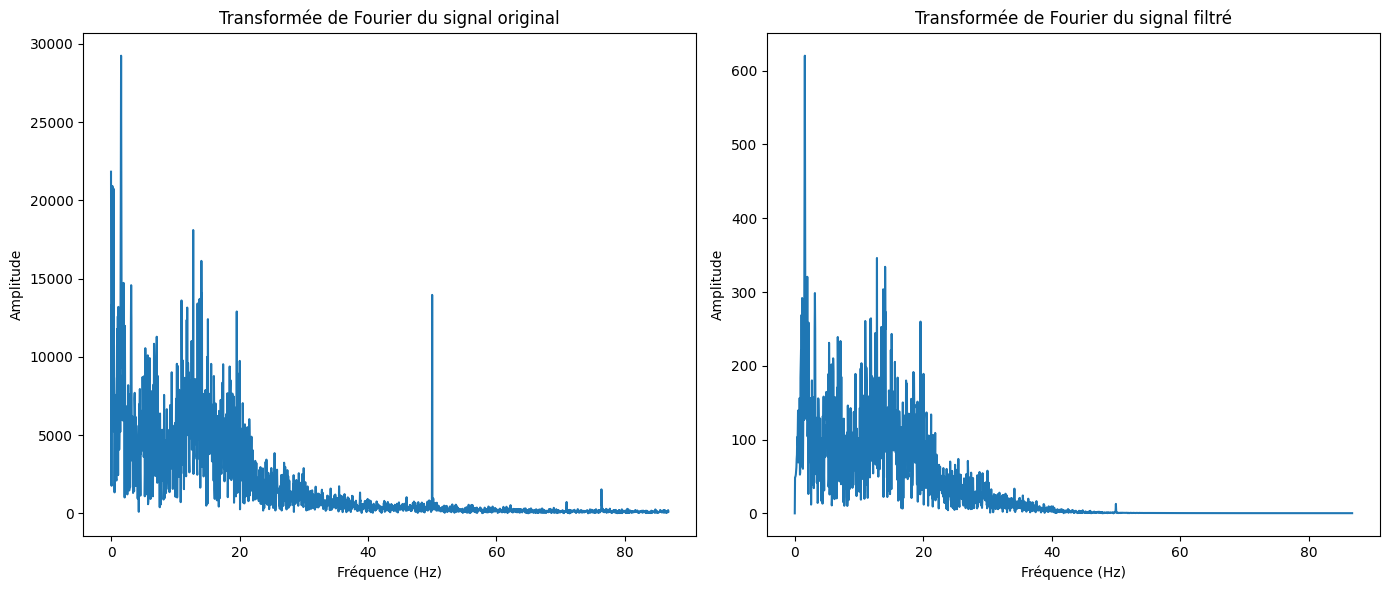

In [4]:
# Transformée de Fourier d'un des signaux filtrés et de sa version originale

# Sélectionner un signal aléatoire
random_index = np.random.randint(0, data.shape[0])
original_signal = data[random_index]
filtered_signal = filtered_signals[random_index]

# Calculer la transformée de Fourier 
original_fft = np.fft.fft(original_signal)
filtered_fft = np.fft.fft(filtered_signal)

# Calculer les fréquences correspondantes
freqs = np.fft.fftfreq(len(original_signal), d=1/sample_rate)

# Ajuster les longueurs pour correspondre
half_n = len(original_signal) // 2
freqs = freqs[:half_n]
original_fft = original_fft[:half_n]
filtered_fft = filtered_fft[:half_n]

# Afficher les résultats
plt.figure(figsize=(14, 6))

# Transformée de Fourier du signal original
plt.subplot(1, 2, 1)
plt.plot(freqs, np.abs(original_fft))
plt.title('Transformée de Fourier du signal original')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

# Transformée de Fourier du signal filtré
plt.subplot(1, 2, 2)
plt.plot(freqs, np.abs(filtered_fft))
plt.title('Transformée de Fourier du signal filtré')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Diviser les données en ensembles d'entraînement, de validation et de test

Dans ce cas, le modèle s'entraine sur toute la base de donnée, comme pour le cas du Classifieur Supervisé

In [5]:
# Définir les tailles pour les ensembles d'entraînement, de validation et de test
train_size = int(0.8 * 100)  # 80 échantillons par classe (80% de 100)
val_size = int(0.2 * 100)    # 20 échantillons par classe (20% de 100)
test_size = 100 - train_size - val_size     # Les échantillons restants pour le test (On ne prend pas d'ensemble de test 
                                            # car la base de donnée est trop petite)

# Initialiser des listes vides pour chaque ensemble
train_data_list = []
val_data_list = []
test_data_list = []

# Diviser chaque classe séparément et combiner les ensembles
for set_start in range(0, len(dataset), 100):  # Chaque set contient 100 échantillons
    set_data = torch.utils.data.Subset(dataset, range(set_start, set_start + 100))
    class_splits = random_split(set_data, [train_size, val_size, test_size])
    train_data_list.append(class_splits[0])
    val_data_list.append(class_splits[1])
    test_data_list.append(class_splits[2])

# Combiner les ensembles divisés en utilisant ConcatDataset
train_data = torch.utils.data.ConcatDataset(train_data_list)
val_data = torch.utils.data.ConcatDataset(val_data_list)
test_data = torch.utils.data.ConcatDataset(test_data_list)

# Créer des DataLoaders pour chaque ensemble
batch_size = 1  # Taille du batch
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Afficher les tailles des ensembles
print("Ensemble d'entraînement :", len(train_data))  
print("Ensemble de validation :", len(val_data))  
print("Ensemble de test :", len(test_data))

Ensemble d'entraînement : 400
Ensemble de validation : 100
Ensemble de test : 0


### Visulation d'un signal et sa version masquée

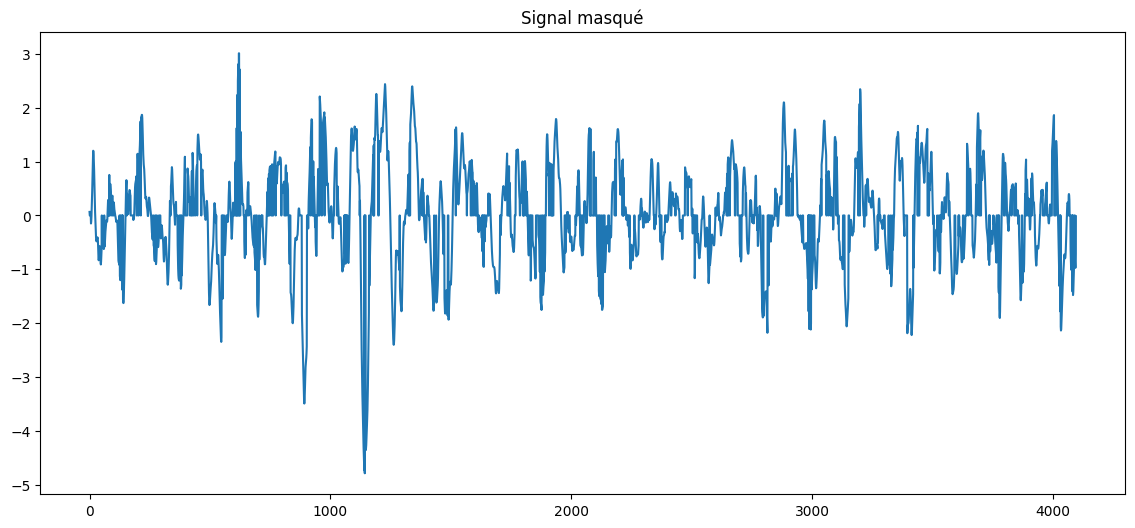

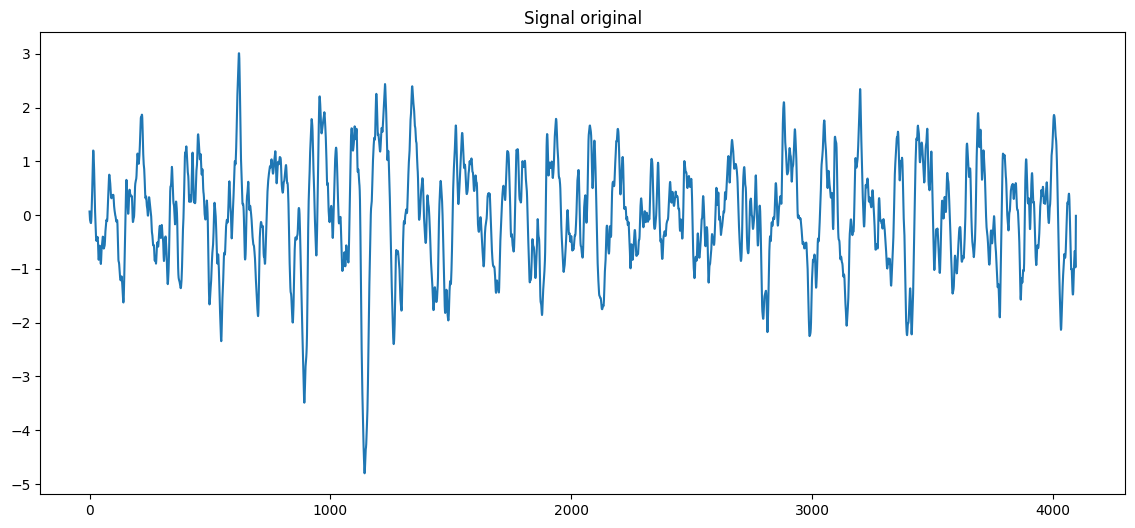

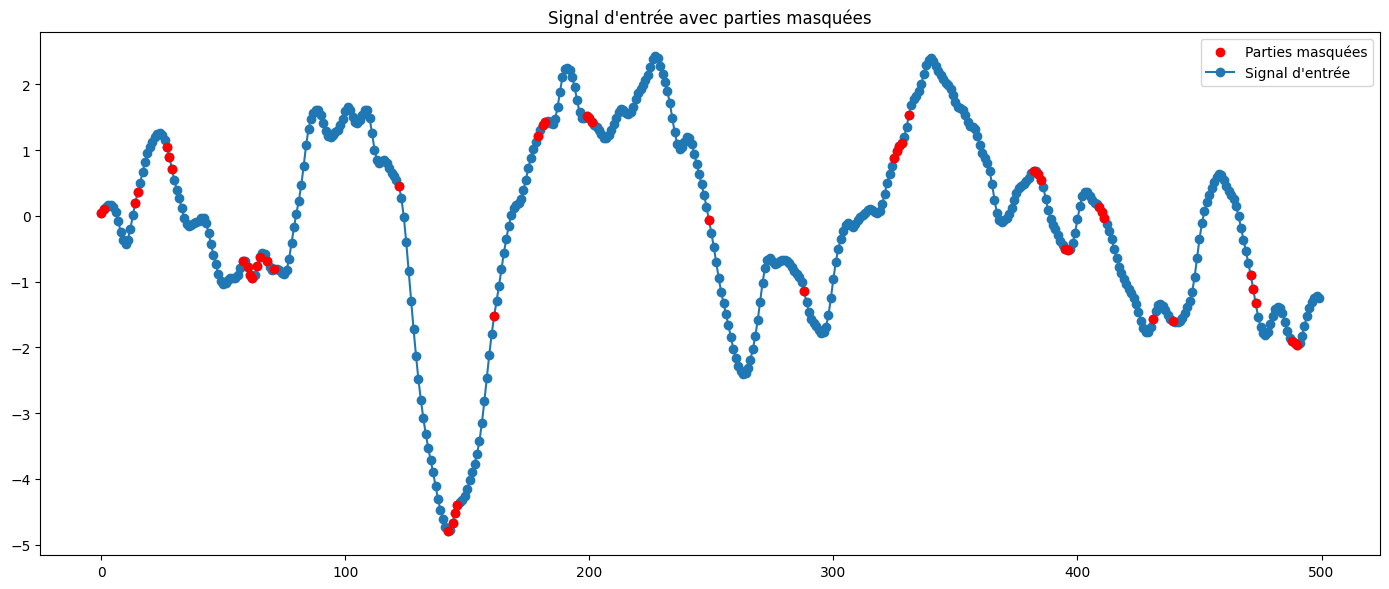

Rapport de 0 par rapport au reste : [0.20087869]


In [6]:
# Sélectionner un batch aléatoire de signaux d'entraînement
dataiter = iter(train_loader)
x_masked, mask, x, labels = next(dataiter)

# Comparaison entre x_masked et x pour un signal aléatoire
random_index = np.random.randint(0, x_masked.shape[0])
signal = x_masked[random_index].squeeze().cpu().numpy()
original_signal = x[random_index].squeeze().cpu().numpy()

# Affichage des signaux masqués et originaux sur deux graphiques différents
plt.figure(figsize=(14, 6))
plt.plot(signal.T)
plt.title("Signal masqué")
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(original_signal.T)
plt.title("Signal original")
plt.show()

# Afficher un signal d'entrée au hasard et ses parties masquées
random_index = np.random.randint(0, x.shape[0])
input_signal = x[random_index].squeeze().cpu().numpy()
mask_signal = mask[random_index].cpu().numpy().squeeze()

plt.figure(figsize=(14, 6))

# Afficher les parties masquées en rouge
masked_indices = np.where(mask_signal[1000:1500] == 0)[0]
plt.scatter(masked_indices, input_signal[masked_indices + 1000], color='red', label='Parties masquées', zorder=3)

# Afficher le signal d'entrée avec les parties masquées
plt.plot(input_signal[1000:1500], marker='o', label='Signal d\'entrée', zorder=1)
plt.title("Signal d'entrée avec parties masquées")
plt.legend()

plt.tight_layout()
plt.show()

# Calculer et afficher le rapport du nombre de 0 par rapport au reste sur les signaux masqués
num_zeros = (x_masked == 0).sum(dim=2).sum(dim=1).cpu().numpy()  # Nombre de 0 dans chaque signal masqué
num_total = x_masked.shape[2]  # Nombre total de valeurs dans chaque signal
zero_ratio = num_zeros / num_total  # Rapport de 0 par rapport au reste

print("Rapport de 0 par rapport au reste :", zero_ratio)


---
---
# Définition de l'architecture du réseau

### Définition du modèle PainAttnNet

Le code ci-dessous a été récupéré sur Github et adapté à notre problème. 

Voici le lien du Github : https://github.com/zhenyuanlu/PainAttnNet 

In [7]:
# Modèle MSCN (Multi-Scale Convolutional Network)
class MSCN(nn.Module):
    def __init__(self, mscn_output_channels, model_dim, kernel_size_short, kernel_size_medium, kernel_size_long, stride_short, stride_medium, stride_long):
        super().__init__()
        dropout = 0.5

        # Définition de la branche à courte échelle
        self.short_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_short, stride_short, dilation=1, bias=False, padding=9), 
            nn.BatchNorm1d(mscn_output_channels), 
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=2, padding=4),
            nn.Dropout(dropout),

            nn.Conv1d(mscn_output_channels, 128, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, mscn_output_channels, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=4, stride=4, padding=2)
        )

        # Définition de la branche à moyenne échelle
        self.medium_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_medium, stride_medium, dilation=1, bias=False, padding=38),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(dropout),

            nn.Conv1d(mscn_output_channels, 128, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, mscn_output_channels, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        # Définition de la branche à longue échelle
        self.long_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_long, stride_long, dilation=1, bias=False, padding=67), 
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=8, padding=0),
            nn.Dropout(dropout),

            nn.Conv1d(mscn_output_channels, 128, kernel_size=8, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, mscn_output_channels, kernel_size=8, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        # Calcul des dimensions de sortie pour les couches linéaires
        x_short_test = self.short_scale(torch.randn(1, 1, 4097))
        x_medium_test = self.medium_scale(torch.randn(1, 1, 4097))
        x_long_test = self.long_scale(torch.randn(1, 1, 4097))
                    
        self.dropout = nn.Dropout(dropout)
        self.fc_short = nn.Linear(x_short_test.shape[2], model_dim)
        self.fc_medium = nn.Linear(x_medium_test.shape[2], model_dim)
        self.fc_long = nn.Linear(x_long_test.shape[2], model_dim)

    def forward(self, x):
        # Passage de l'entrée à travers les différentes branches
        x_short1 = self.short_scale(x)
        x_medium1 = self.medium_scale(x)
        x_long1 = self.long_scale(x)

        # Passage des sorties des branches à travers les couches linéaires
        x_short2 = self.fc_short(x_short1)
        x_medium2 = self.fc_medium(x_medium1)
        x_long2 = self.fc_long(x_long1)

        # Concatenation des sorties
        x_concat = torch.cat((x_short2, x_medium2, x_long2), dim=1)

        # Application du dropout
        x_concat = self.dropout(x_concat)

        return x_concat, x_short1, x_medium1, x_long1


In [8]:
# Modèle SEResNet (Réseau résiduel avec blocs de squeeze-and-excitation)

"""
Ce module contient l'implémentation de l'architecture SEResNet.
"""

import torch.nn as nn

# Définition du bloc Squeeze-and-Excitation.
class SENet(nn.Module):
    """
    Bloc Squeeze-and-Excitation pour l'attention par canal.
    """

    def __init__(self, channels, reduction=16): 
        super(SENet, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)  # Multiplie l'entrée par les poids d'attention


# Définition du bloc de base qui prépare l'entrée avant de l'envoyer au bloc SE et ajoute l'entrée globale à la sortie du bloc SE.
class SEBasicBlock(nn.Module):
    """
    Bloc de base pour les réseaux squeeze-and-excitation avec d'autres couches.
    """
    expansion = 1

    def __init__(self, input_channels, output_channels, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, input_channels // 2, stride)
        self.bn1 = nn.BatchNorm1d(input_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(input_channels // 2, output_channels, 1)
        self.bn2 = nn.BatchNorm1d(output_channels)
        self.se = SENet(output_channels, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        # Première couche convolutionnelle
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Deuxième couche convolutionnelle
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        # Downsample si nécessaire
        if self.downsample is not None:
            residual = self.downsample(x)

        # Ajoute la connexion résiduelle et applique ReLU
        out += residual
        out = self.relu(out)

        return out


# Création de l'architecture ResNet avec 'block_size' instances de SEBasicBlock mises bout à bout.
class SEResNet(nn.Module):
    """
    Réseau résiduel avec blocs de squeeze-and-excitation.

    Le downsampling est effectué par conv1 lorsque stride != 1 ou
    lorsque la taille des input_channels n'est pas égale à la taille de sortie.
    """
    def __init__(self, output_channels, block_size, mscn_output_channels_times3):
        super(SEResNet, self).__init__()
        self.input_channels = mscn_output_channels_times3  # Nombre de cartes de caractéristiques en entrée
        self.block = SEBasicBlock
        self.layer = self._make_layer(self.block, output_channels, block_size)

    def _make_layer(self, block, output_channels, blocks, stride=1):
        downsample = self._downsample_layer(self.input_channels, output_channels * block.expansion, stride)

        layers = [block(self.input_channels, output_channels, stride, downsample)]
        self.input_channels = output_channels * block.expansion
        layers.extend(block(self.input_channels, output_channels) for _ in range(1, blocks))

        return nn.Sequential(*layers)

    @staticmethod
    def _downsample_layer(input_channels, output_channels, stride):
        if stride != 1 or input_channels != output_channels:
            return nn.Sequential(
                nn.Conv1d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(output_channels)
            )
        return None

    def forward(self, x):
        return self.layer(x)


In [9]:
# Modèle TransformerEncoder (Encodeur Transformer)

# Fonction utilitaire pour cloner des modules
def clones(module, N): 
    """
    Génère N couches identiques

    Args:
        module (nn.Module): Module PyTorch à cloner
        N (int): Nombre de clones à créer

    Returns:
        nn.ModuleList: Liste de N modules PyTorch clonés
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class TCN(nn.Module):
    """
    Réseau de Convolution Temporelle avec padding causal, connexions résiduelles et normalisation par lot

    Lorsque kernel_size est égal à zéro, le padding n'est pas causal
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, causal=True):
        super(TCN, self).__init__()
        padding = (kernel_size - 1) * dilation if causal else 0
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.causal = causal
        self.tcn_padding = padding
        self.downsample = None

        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        out = self.bn2(self.conv2(out))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class MultiHeadAttention(nn.Module):
    """
    Attention Multi-Tête avec TCN
    """
    def __init__(self, num_heads, model_dim, se_reduced_size, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.tcn = clones(TCN(se_reduced_size, se_reduced_size, kernel_size=7), 2)
        self.multihead_attention = nn.MultiheadAttention(se_reduced_size, num_heads, batch_first=True, dropout=dropout)

    def forward(self, query, key, value):
        """
        On échange les dimensions seq et channel pour les tenseurs d'entrée
        afin de répondre aux exigences de nn.MultiheadAttention()
        """
        query = query.transpose(1, 2)
        key = self.tcn[0](key).transpose(1, 2)
        value = self.tcn[1](value).transpose(1, 2)
        attn_output, attn_output_weights = self.multihead_attention(query, key, value)
        attn_output = attn_output.transpose(1, 2)
        return attn_output

class MLP(nn.Module):
    """
    Perceptron Multi-Couche
    """
    def __init__(self, model_dim, d_mlp, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(model_dim, d_mlp)
        self.w_2 = nn.Linear(d_mlp, model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Passage avant du MLP
        """
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class LayerNorm(nn.Module):
    """
    Normalisation de Couche
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerOutput(nn.Module):
    """
    Connexion résiduelle suivie d'une normalisation de couche.
    """
    def __init__(self, se_reduced_size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = nn.LayerNorm(se_reduced_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Applique une connexion résiduelle à n'importe quelle sous-couche de même taille.
        """
        normalized_x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        return x + self.dropout(sublayer(normalized_x))

class TransformerEncoder(nn.Module):
    """
    Encodeur Transformer

    Intégration de MHA et MLP.
    Chacune de ces sous-couches a une connexion résiduelle et une normalisation de couche, implémentées par SublayerOutput.
    """
    def __init__(self, model_dim, self_attn, feed_forward, se_reduced_size, dropout):
        super(TransformerEncoder, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = clones(SublayerOutput(se_reduced_size, dropout), 2)
        self.size = model_dim
        self.conv = TCN(se_reduced_size, se_reduced_size, kernel_size=7)

    def forward(self, x_in):
        query = self.conv(x_in)
        # Auto-attention de l'encodeur
        x = self.sublayer_output[0](query, lambda x: self.self_attn(query, x_in, x_in))
        return self.sublayer_output[1](x, self.feed_forward)

class EncoderWrapper(nn.Module):
    """
    Wrapper de l'Encodeur Transformer

    C'est une pile de N couches d'encodeur transformer, par défaut N=2.
    """
    def __init__(self, num_heads, model_dim, se_reduced_size, d_mlp, dropout, N):
        super(EncoderWrapper, self).__init__()
        attn = MultiHeadAttention(num_heads, model_dim, se_reduced_size)
        mlp = MLP(model_dim, d_mlp, dropout)
        layer = TransformerEncoder(model_dim, deepcopy(attn), deepcopy(mlp), se_reduced_size, dropout)
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [10]:
# Bloc résiduel générique pour les convolutions 1D avec upsampling
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, upsample_scale=None, dropout_rate=0.2):
        super(ResidualBlock1D, self).__init__()
        self.upsample = nn.Upsample(scale_factor=upsample_scale, mode='linear', align_corners=True) if upsample_scale else None
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.batchnorm1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.batchnorm2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.adjust_residual = nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        if self.upsample:
            x = self.upsample(x)
            residual = self.upsample(residual)
        if self.adjust_residual:
            residual = self.adjust_residual(residual)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        x = x + residual  # Addition élément par élément
        x = self.relu(x)  # Activation finale
        return x

# Décodeur de signal utilisant des blocs résiduels
class SignalDecoder(nn.Module):
    def __init__(self, previous_feat_size, model_dim, dropout_rate=0.5):
        super(SignalDecoder, self).__init__()
        self.feature_size = previous_feat_size
        self.time_size = model_dim
        factor = 4096 // self.time_size

        # Définition des blocs résiduels avec upsampling
        self.block1 = ResidualBlock1D(previous_feat_size, previous_feat_size, kernel_size=3, upsample_scale=2, dropout_rate=dropout_rate)
        self.block2 = ResidualBlock1D(previous_feat_size, previous_feat_size, kernel_size=3, upsample_scale=2, dropout_rate=dropout_rate)

        # Convolution et normalisation
        self.upsample1 = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        self.conv1 = nn.Conv1d(previous_feat_size, 64, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.upsample2 = nn.Upsample(scale_factor=factor // 8, mode='linear', align_corners=True)
        self.conv2 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(1)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        # Convolution finale pour ajuster la dimension
        self.final_projection = nn.Conv1d(1, 1, kernel_size=2, padding=1)
        self.scale = nn.Parameter(torch.ones(1))  # Facteur d'échelle

        # Initialisation des poids
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Passer à travers les blocs résiduels
        decoder = self.block1(x)
        decoder = self.block2(decoder)

        # Convolution et normalisation
        decoder = self.upsample1(decoder)
        decoder = self.conv1(decoder)
        decoder = self.batchnorm1(decoder)
        decoder = self.dropout1(decoder)

        # Convolution et normalisation
        decoder = self.upsample2(decoder)
        decoder = self.conv2(decoder)
        decoder = self.batchnorm2(decoder)
        decoder = self.dropout2(decoder)

        # Convolution finale et projection
        out = self.final_projection(decoder).squeeze(1)
        out = out * self.scale  # Appliquer le facteur d'échelle
        return out


### Instanciation du modèle complet

In [11]:
import torch
from torchsummary import summary

# PainAttnNet model
"""
main_painAttnNet.py

PainAttnNet model: Le modèle principal de l'article
Modules: MSCN, SEResNet, et Transformer Encoder
"""

import torch.nn as nn

# Initialisation des poids
def initialize_weights(module):
    if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)

class PainAttnNet(nn.Module):
    """
    Modèle PainAttnNet
    """
    def __init__(self):
        super(PainAttnNet, self).__init__()

        # Nombre de piles d'encodeurs Transformer
        N = 1
        # Dimension du modèle provenant de MSCN
        model_dim = 256
        # Nombre de têtes d'attention
        num_heads = 8
        # Taux de dropout
        dropout = 0.1
        # Taille réduite de SEResNet
        senet_reduced_size = 32
        # Dimension du MLP dans l'encodeur Transformer
        d_mlp = senet_reduced_size * 4

        # Paramètres MSCN
        mscn_output_channels = 32
        kernel_size_short = 9
        kernel_size_medium = 37
        kernel_size_long = 67
        stride_short = 1
        stride_medium = 5
        stride_long = 9

        # Modules
        self.mscn = MSCN(
            mscn_output_channels, model_dim,
            kernel_size_short, kernel_size_medium, kernel_size_long,
            stride_short, stride_medium, stride_long
        )
        self.seresnet = SEResNet(senet_reduced_size, 1, mscn_output_channels * 3)
        self.encoderWrapper = EncoderWrapper(num_heads, model_dim, senet_reduced_size, d_mlp, dropout, N)
        self.decoder = SignalDecoder(senet_reduced_size, model_dim)

        # Initialisation des poids
        self.apply(initialize_weights)

    def forward(self, x):
        """
        Passage avant à travers le modèle.
        """
        # Réseau Convolutionnel Multi-Échelle (MSCN)
        mscn_feat, _, _, _ = self.mscn(x)
        
        # SEResNet
        se_feat = self.seresnet(mscn_feat)
        
        # Encodeur Transformer
        transformer_feat = self.encoderWrapper(se_feat)
        
        # Décodeur
        decoded_output = self.decoder(transformer_feat)
        
        return decoded_output, transformer_feat, mscn_feat  # Retourner les caractéristiques latentes pour l'analyse

    def extract_latent_space(self, x):
        """
        Extraire la représentation de l'espace latent du modèle.
        """
        _, transformer_feat, _ = self.forward(x)
        return transformer_feat

# Instanciation du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PainAttnNet().to(device)

# Résumé du modèle
summary(model, input_size=(1, 4097))
print(f"Nombre total de paramètres : {sum(p.numel() for p in model.parameters())}")

# Exemple d'extraction d'espace latent
x = torch.randn(1, 1, 4097).to(device)  # Exemple de signal d'entrée
_, latent_space1, latent_space2 = model(x)  # Extraire l'espace latent
print(f"Dimensions de l'espace latent après Transformer : {latent_space1.shape}")
print(f"Dimensions de l'espace latent après MSCN : {latent_space2.shape}")

# Préparation pour l'analyse PCA
latent_np1 = latent_space1.view(latent_space1.shape[0], -1).cpu().detach().numpy()
latent_np2 = latent_space2.view(latent_space2.shape[0], -1).cpu().detach().numpy()
print(f"Forme de l'espace latent aplati après Transformer : {latent_np1.shape}")
print(f"Forme de l'espace latent aplati après MSCN : {latent_np2.shape}")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 4107]             288
       BatchNorm1d-2             [-1, 32, 4107]              64
              GELU-3             [-1, 32, 4107]               0
         MaxPool1d-4             [-1, 32, 2054]               0
           Dropout-5             [-1, 32, 2054]               0
            Conv1d-6            [-1, 128, 2055]          32,768
       BatchNorm1d-7            [-1, 128, 2055]             256
              GELU-8            [-1, 128, 2055]               0
            Conv1d-9             [-1, 32, 2056]          32,768
      BatchNorm1d-10             [-1, 32, 2056]              64
             GELU-11             [-1, 32, 2056]               0
        MaxPool1d-12              [-1, 32, 515]               0
           Conv1d-13              [-1, 32, 828]           1,184
      BatchNorm1d-14              [-1, 

Epoch 1/100 [Validation]: 100%|██████████| 100/100 [00:06<00:00, 14.57it/s]


Current learning rate: 0.001000


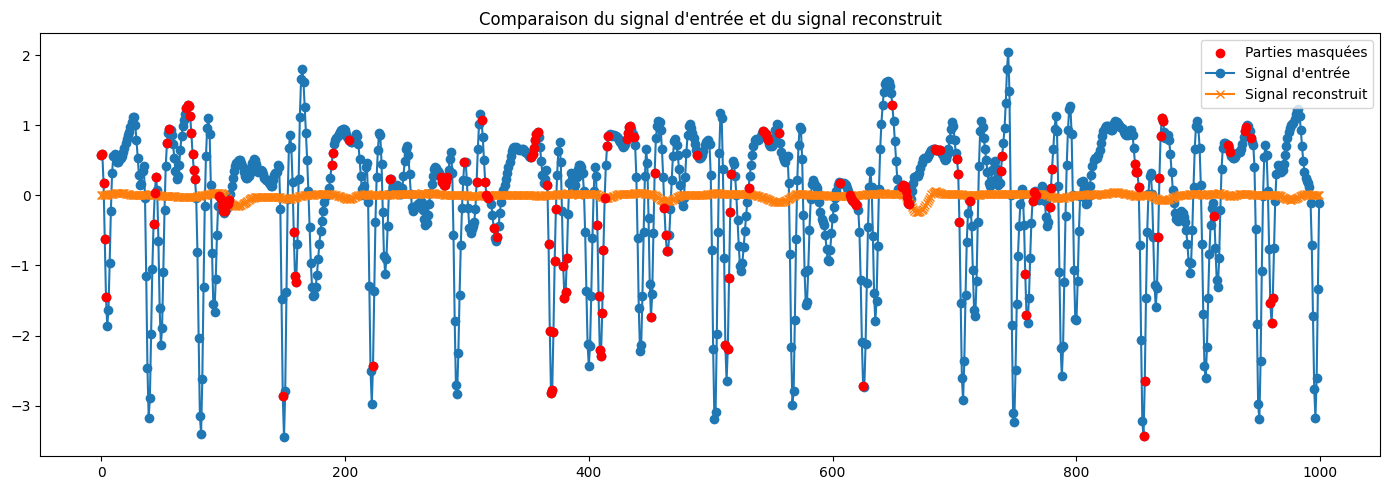

Epoch 1: Train Loss: 100.110201, Valid Loss: 84.903252


Epoch 2/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


Epoch 2: Train Loss: 83.985680, Valid Loss: 81.881925


Epoch 3/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 14.08it/s]


Epoch 3: Train Loss: 81.575457, Valid Loss: 80.194503


Epoch 4/100 [Validation]: 100%|██████████| 100/100 [00:09<00:00, 10.63it/s]


Epoch 4: Train Loss: 80.205591, Valid Loss: 79.641095


Epoch 5/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 13.96it/s]


Epoch 5: Train Loss: 79.336843, Valid Loss: 79.037988


Epoch 6/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


Current learning rate: 0.001000


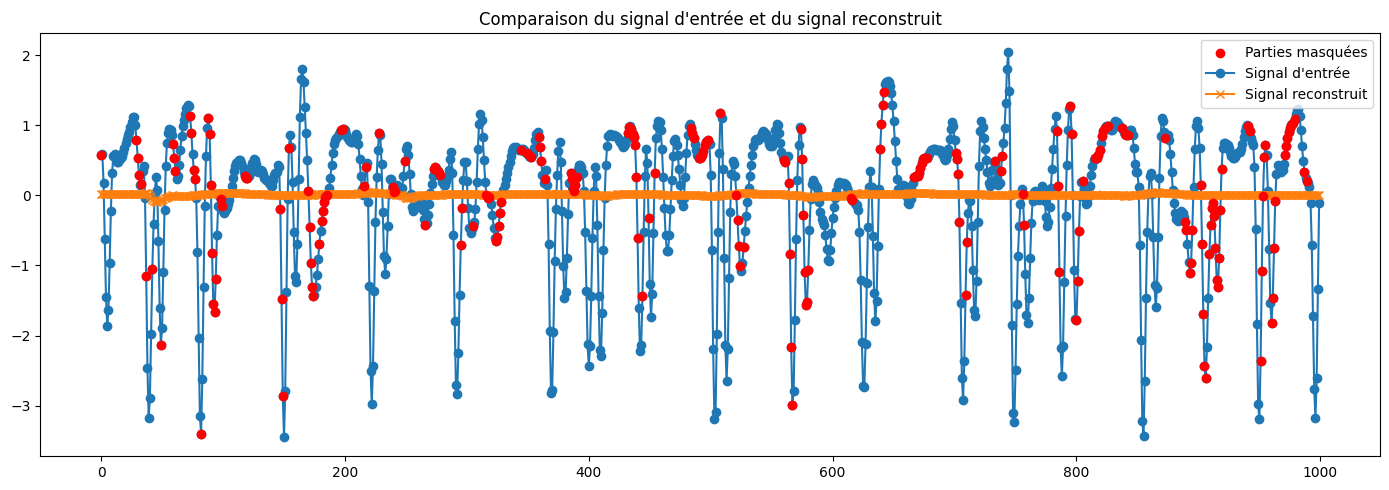

Epoch 6: Train Loss: 78.852966, Valid Loss: 78.709770


Epoch 7/100 [Validation]: 100%|██████████| 100/100 [00:06<00:00, 14.47it/s]


Epoch 7: Train Loss: 76.091252, Valid Loss: 71.557750


Epoch 8/100 [Validation]: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


Epoch 8: Train Loss: 70.448546, Valid Loss: 63.998447


Epoch 9/100 [Validation]: 100%|██████████| 100/100 [00:06<00:00, 14.38it/s]


Epoch 9: Train Loss: 66.181196, Valid Loss: 59.297969


Epoch 10/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


Epoch 10: Train Loss: 63.809434, Valid Loss: 57.033701


Epoch 11/100 [Validation]: 100%|██████████| 100/100 [00:06<00:00, 14.97it/s]


Current learning rate: 0.001000


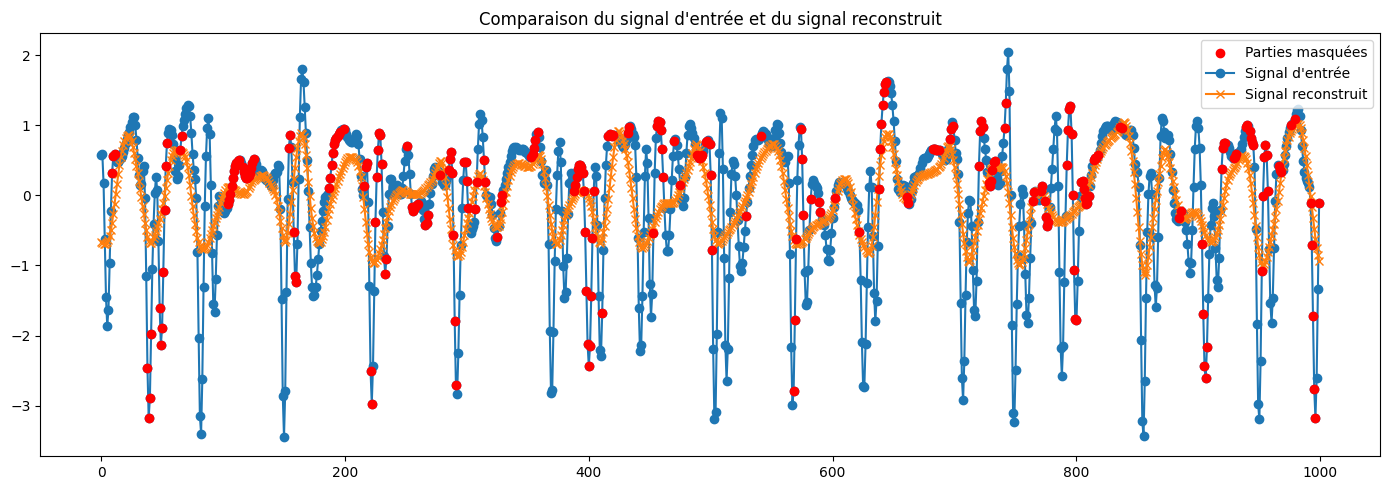

Epoch 11: Train Loss: 62.422363, Valid Loss: 54.460233


Epoch 12/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 14.10it/s]


Epoch 12: Train Loss: 61.432371, Valid Loss: 53.503408


Epoch 13/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 13.28it/s]


Epoch 13: Train Loss: 60.730158, Valid Loss: 52.865019


Epoch 14/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 14.20it/s]


Epoch 14: Train Loss: 60.166832, Valid Loss: 51.553392


Epoch 15/100 [Validation]: 100%|██████████| 100/100 [00:06<00:00, 14.44it/s]


Epoch 15: Train Loss: 59.685051, Valid Loss: 51.276946


Epoch 16/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


Current learning rate: 0.001000


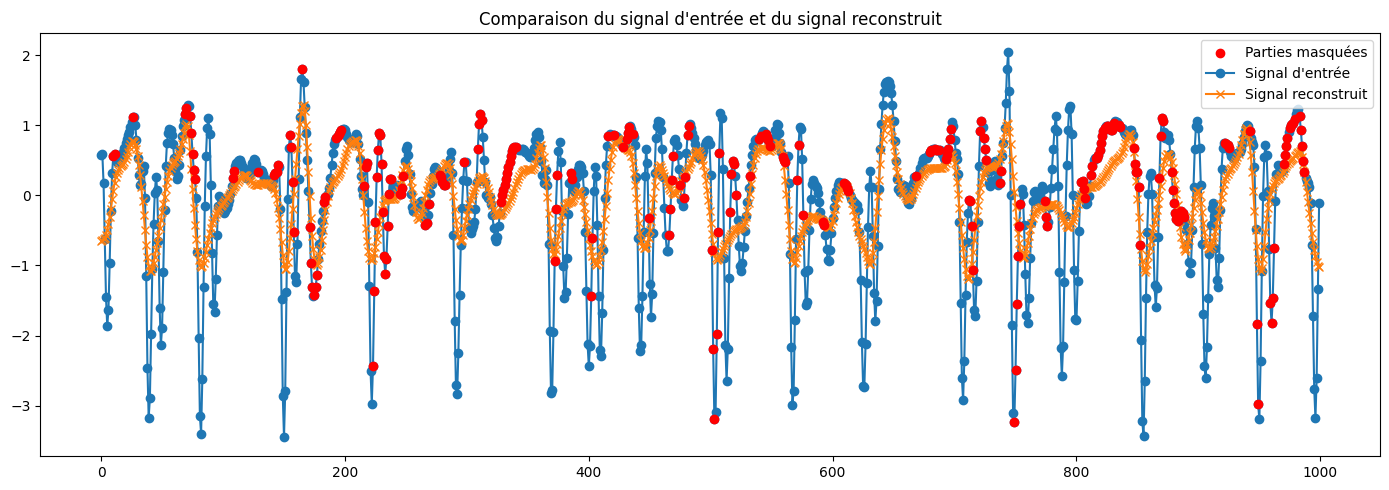

Epoch 16: Train Loss: 59.232993, Valid Loss: 50.219041


Epoch 17/100 [Validation]: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


Epoch 17: Train Loss: 58.886365, Valid Loss: 49.847589


Epoch 18/100 [Validation]: 100%|██████████| 100/100 [00:06<00:00, 14.38it/s]


Epoch 18: Train Loss: 58.521942, Valid Loss: 49.004001


Epoch 19/100 [Validation]: 100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


Epoch 19: Train Loss: 58.200480, Valid Loss: 48.351592


Epoch 20/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


Epoch 20: Train Loss: 58.010287, Valid Loss: 48.418753


Epoch 21/100 [Validation]: 100%|██████████| 100/100 [00:06<00:00, 14.76it/s]


Current learning rate: 0.001000


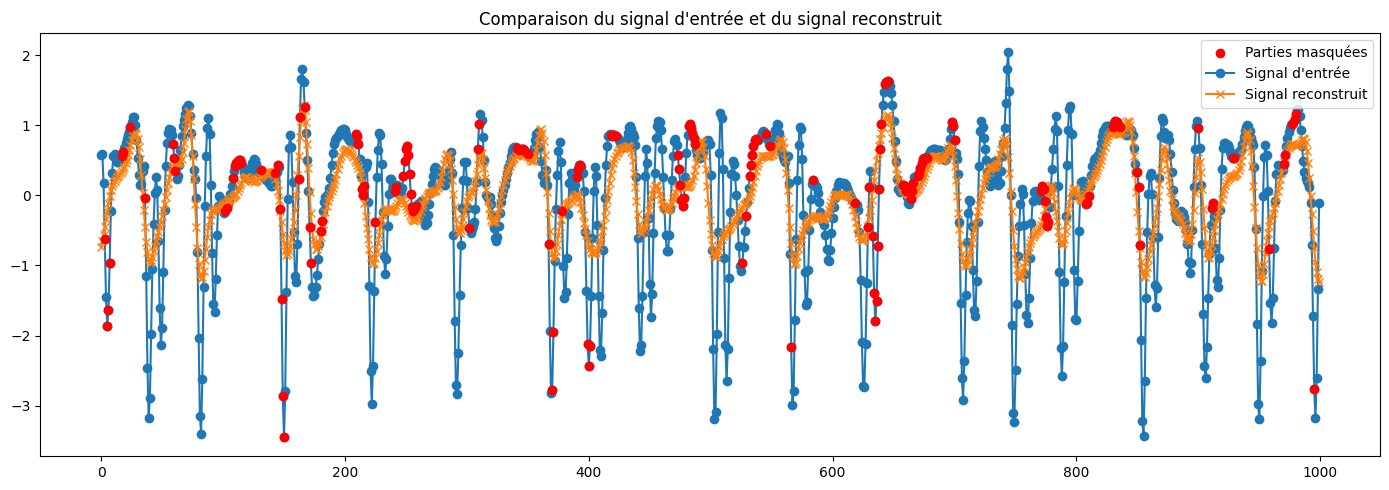

Epoch 21: Train Loss: 57.715055, Valid Loss: 48.106737


Epoch 22/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


Epoch 22: Train Loss: 57.476665, Valid Loss: 48.353447


Epoch 23/100 [Validation]: 100%|██████████| 100/100 [00:06<00:00, 14.34it/s]


Epoch 23: Train Loss: 57.399055, Valid Loss: 48.922075


Epoch 24/100 [Validation]: 100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


Epoch 24: Train Loss: 57.284528, Valid Loss: 48.524154


Epoch 25/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


Epoch 25: Train Loss: 56.474236, Valid Loss: 47.221441


Epoch 26/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


Current learning rate: 0.000500


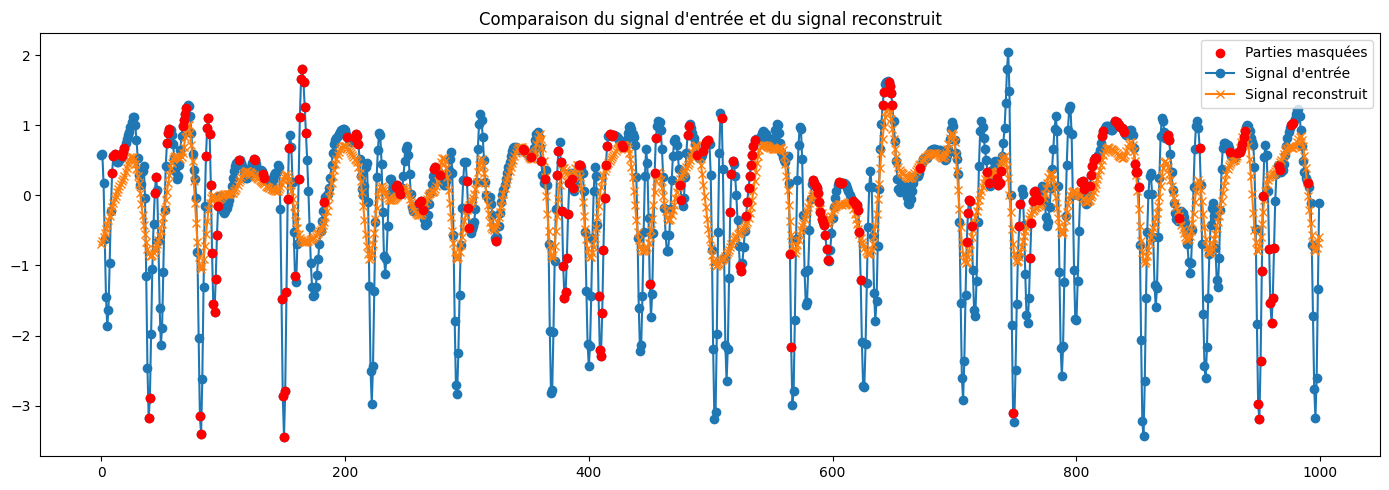

Epoch 26: Train Loss: 55.979682, Valid Loss: 48.303688


Epoch 27/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


Epoch 27: Train Loss: 55.628748, Valid Loss: 46.412199


Epoch 28/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


Epoch 28: Train Loss: 55.546667, Valid Loss: 46.273085


Epoch 29/100 [Validation]: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


Epoch 29: Train Loss: 55.447970, Valid Loss: 46.115311


Epoch 30/100 [Validation]: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


Epoch 30: Train Loss: 55.368287, Valid Loss: 45.711791


Epoch 31/100 [Validation]: 100%|██████████| 100/100 [00:11<00:00,  8.62it/s]


Current learning rate: 0.000500


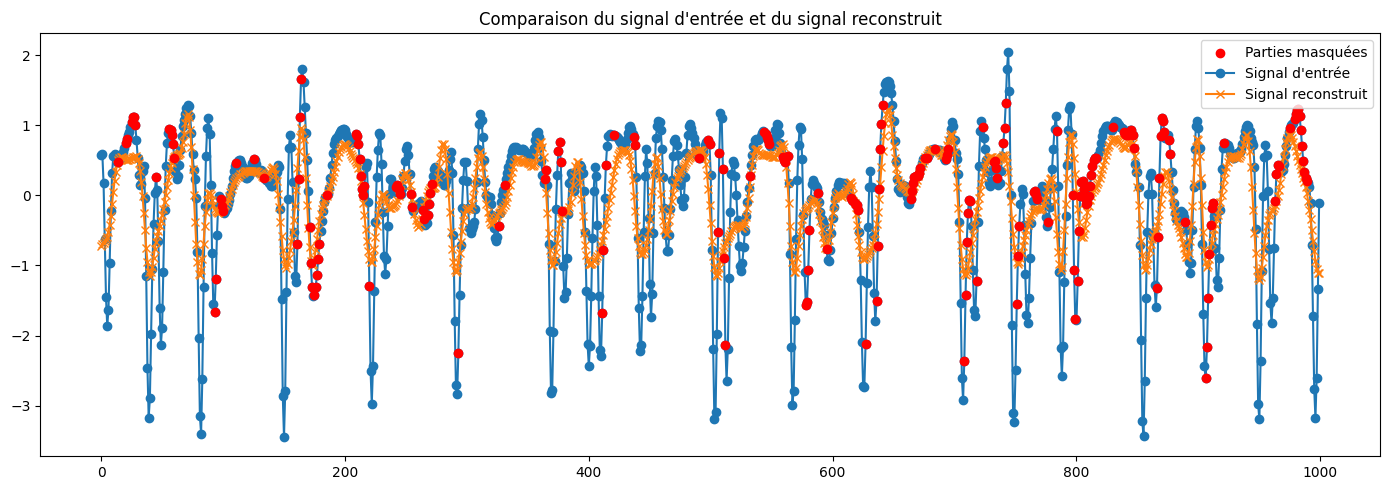

Epoch 31: Train Loss: 55.219746, Valid Loss: 45.963067


Epoch 32/100 [Validation]: 100%|██████████| 100/100 [00:08<00:00, 12.21it/s]


Epoch 32: Train Loss: 55.091337, Valid Loss: 46.477304


Epoch 33/100 [Training]:  58%|█████▊    | 234/400 [00:23<00:16,  9.81it/s]


KeyboardInterrupt: 

In [12]:
# Entraînement du modèle
learning_rate = 0.001
n_epochs = 100

# Spécification de la fonction de perte
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

# Optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Scheduler pour réduire le learning rate si la validation stagne
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Listes pour suivre les métriques
train_losses = []
valid_losses = []
train_reconstruction_errors = []
valid_reconstruction_errors = []

# Suivi de la meilleure validation loss
best_valid_loss = float('inf')
best_model = None
best_epoch = 0

# Boucle d'entraînement
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    running_mse = 0.0

    # Barre de progression pour l'entraînement
    trainloader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Training]")

    for batch_data in trainloader:
        # Décomposer les données du batch
        x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]
        mask = mask.squeeze(1).bool()
        x_original = x_original.squeeze(1)

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Forward pass
        output, _, _ = model(x_masked)

        # Calcul de la perte
        loss = criterion(output, x_original)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Mise à jour des métriques
        train_loss += loss.item() * x_masked.size(0)
        running_mse += F.mse_loss(output, x_original, reduction='mean').item()

    # Moyenne des métriques d'entraînement
    train_loss /= len(train_loader.dataset)
    train_reconstruction_error = running_mse / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_reconstruction_errors.append(train_reconstruction_error)

    # Étape de validation
    model.eval()
    valid_loss = 0.0
    valid_reconstruction_error = 0.0

    with torch.no_grad():
        validloader = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Validation]")
        for batch_data in validloader:
            x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]
            mask = mask.squeeze(1).bool()
            x_original = x_original.squeeze(1)

            # Forward pass
            output, _, _ = model(x_masked)

            # Calcul de la perte
            loss = criterion(output, x_original)
            valid_loss += loss.item() * x_masked.size(0)

            # Calcul de l'erreur de reconstruction
            valid_reconstruction_error += F.mse_loss(output, x_original, reduction='mean').item() * x_masked.size(0)

    # Moyenne des métriques de validation
    valid_loss /= len(valid_loader.dataset)
    valid_reconstruction_error /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    valid_reconstruction_errors.append(valid_reconstruction_error)

    # Mise à jour du scheduler
    scheduler.step(valid_loss)

    # Affichage du learning rate et des graphiques tous les 5 epochs
    if epoch % 5 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Current learning rate: {current_lr:.6f}")
        plt.figure(figsize=(14, 5))
        masked_indices = np.where(x_masked.squeeze().cpu().numpy()[1000:2000] == 0)[0]
        plt.scatter(masked_indices, x_original.squeeze().cpu().numpy()[masked_indices + 1000], color='red', label='Parties masquées', zorder=3)
        plt.plot(x_original.squeeze().cpu().numpy()[1000:2000], marker='o', label='Signal d\'entrée', zorder=1)
        plt.plot(output.squeeze().cpu().numpy()[1000:2000], marker='x', label='Signal reconstruit', zorder=2)
        plt.title("Comparaison du signal d'entrée et du signal reconstruit")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Affichage des résultats pour l'époque
    print(f"Epoch {epoch+1}: Train Loss: {train_loss*100:.6f}, Valid Loss: {valid_loss*100:.6f}")

    # Sauvegarde du meilleur modèle
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = model.state_dict()
        best_epoch = epoch + 1

# Chargement et sauvegarde du meilleur modèle après l'entraînement
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')

print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss*100:.6f}")

### Affichage de la courbe d'entraînement

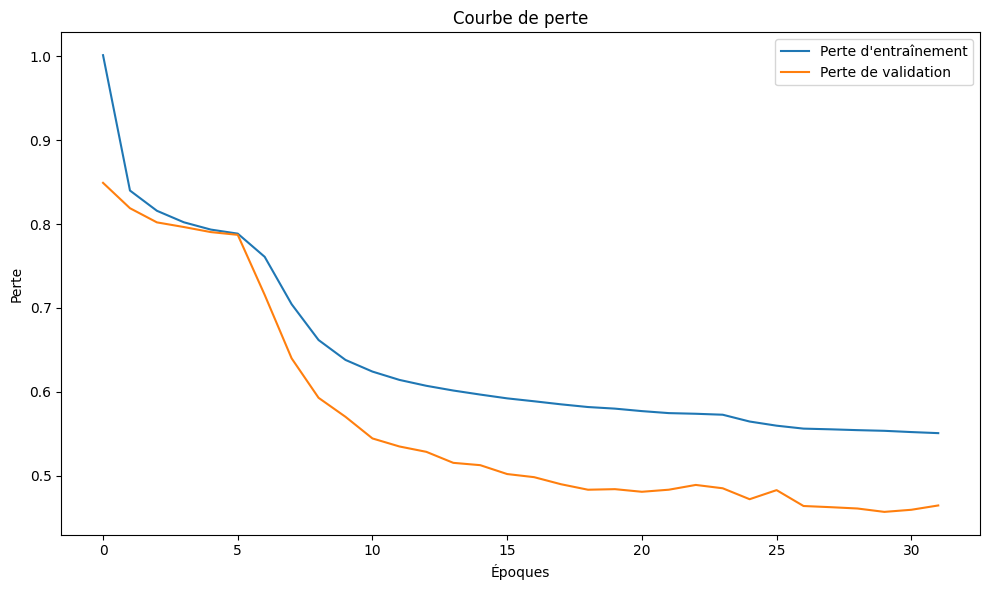

Meilleur modèle sélectionné à l'époque 30 avec une perte de validation de : 0.457118


In [13]:
# Tracer les courbes de perte
plt.figure(figsize=(10, 6))

# Tracer la perte d'entraînement et de validation
plt.plot(train_losses, label='Perte d\'entraînement')
plt.plot(valid_losses, label='Perte de validation')
plt.title('Courbe de perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

# Afficher l'époque avec le meilleur modèle et la perte de validation correspondante
print(f"Meilleur modèle sélectionné à l'époque {best_epoch} avec une perte de validation de : {best_valid_loss:.6f}")

---
---

## Test du Réseau entrainé

Test Loss: 0.468348



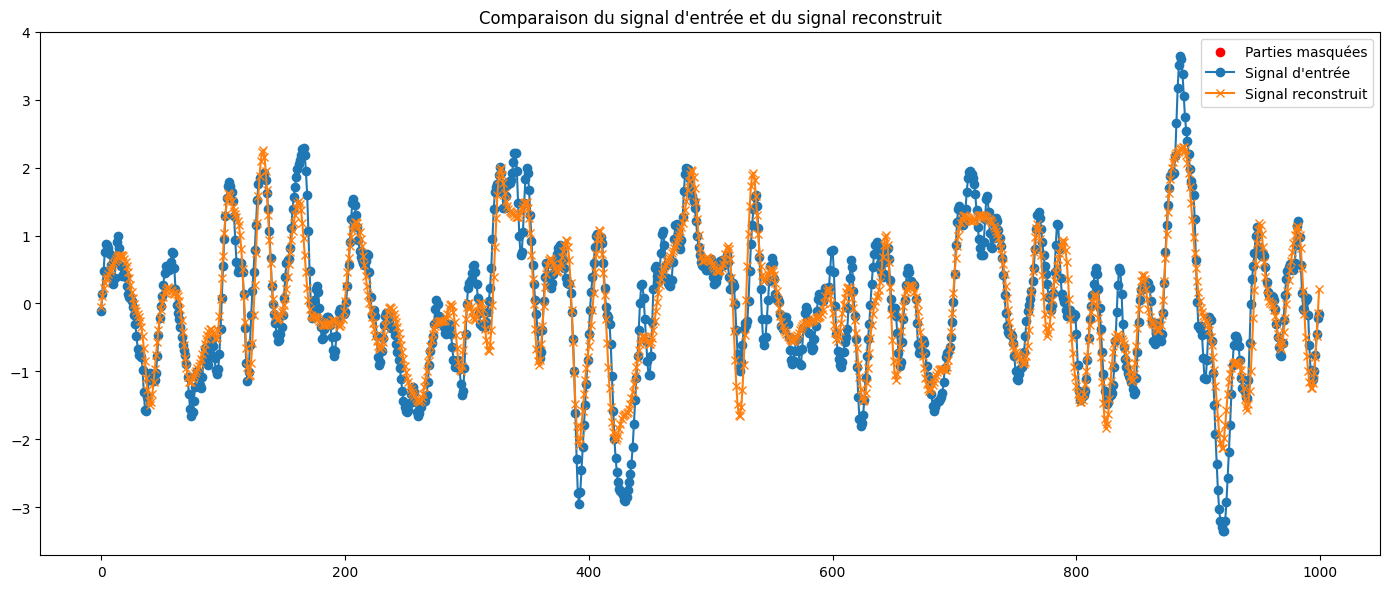

In [14]:
# Charger le best_model enregistré
model.load_state_dict(best_model)
model.eval()  # Préparer le modèle pour l'évaluation

# Initialiser les listes pour surveiller la perte de test et la précision
test_loss = 0.0

# Désactiver le calcul des gradients pour l'évaluation
with torch.no_grad():
    for batch_data in valid_loader:
        # Décomposer les données du batch (x_masked, mask, x_original, labels)
        x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]

        # Assurez-vous que le masque est de type booléen
        mask = mask.squeeze(1).bool()

        # Supprimer la dimension supplémentaire de x_original
        x_original = x_original.squeeze(1)
        
        # Forward pass : calculer les sorties prédites en passant les entrées au modèle
        output, latent_space1, latent_space2 = model(x_masked)
        
        # Calculer la perte
        loss = criterion(output, x_original)
        
        # Mettre à jour la perte de test
        test_loss += loss.item() * x_masked.size(0)

# Calculer et afficher la perte moyenne de test
test_loss = test_loss / len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Prendre un batch au hasard dans valid_loader
random_index_batch = np.random.randint(0, len(valid_loader.dataset))
for i, batch_data in enumerate(valid_loader):
    if i == random_index_batch:
        x_masked, mask, x_original, _ = [item.to(device).float() for item in batch_data]
        output, latent_space1, latent_space2 = model(x_masked)

# Afficher un signal d'entrée au hasard et sa reconstruction
random_index = np.random.randint(0, x_original.shape[0])
input_signal = x_original[random_index].squeeze().cpu().detach().numpy()
reconstructed_signal = output[random_index].squeeze().cpu().detach().numpy()
mask_signal = mask[random_index].cpu().detach().numpy()

plt.figure(figsize=(14, 6))

# Afficher les parties masquées en rouge
masked_indices = np.where(mask_signal[1000:2000] == 0)[0]
plt.scatter(masked_indices, input_signal[masked_indices + 1000], color='red', label='Parties masquées', zorder=3)

# Afficher le signal d'entrée et le signal reconstruit sur le même graphique
plt.plot(input_signal[1000:2000] - np.mean(input_signal), marker='o', label='Signal d\'entrée', zorder=1)
plt.plot(1.5 * reconstructed_signal[1000:2000], marker='x', label='Signal reconstruit', zorder=2)

plt.title("Comparaison du signal d'entrée et du signal reconstruit")
plt.legend()

plt.tight_layout()
plt.show()

---
---

# Analyse de l'espace Latent après le MSCN et après le Transformer

### Visualisation par Analyse en Composantes Principales

In [68]:
# Projection de l'espace latent avec PCA

import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import torch

# Initialisation des tenseurs pour les labels et les espaces latents
labels = torch.tensor([]).to(device)
latent_space1 = torch.tensor([]).to(device)
latent_space2 = torch.tensor([]).to(device)

# Supposons que transformer_feat est un tenseur PyTorch, et labels est également un tenseur PyTorch
with torch.no_grad():
    for batch_data in valid_loader:
        x_masked, _, _, label = [item.to(device).float() for item in batch_data]
        labels = torch.cat((labels, label), 0)
        _, latent1, latent2 = model(x_masked)
        latent_space1 = torch.cat((latent_space1, latent1), 0)
        latent_space2 = torch.cat((latent_space2, latent2), 0)

# Détachement des tenseurs et transfert sur CPU
latent_space1 = latent_space1.detach().cpu()
latent_space2 = latent_space2.detach().cpu()

# Vérification et aplatissement des dimensions des tenseurs pour PCA
if latent_space1.dim() > 2:
    latent_space1 = latent_space1.contiguous().view(latent_space1.shape[0], -1)

if latent_space2.dim() > 2:
    latent_space2 = latent_space2.contiguous().view(latent_space2.shape[0], -1)

# Conversion des tenseurs en tableaux NumPy pour PCA
latentspace1 = latent_space1.numpy()
latentspace2 = latent_space2.numpy()
target_np = labels.cpu().numpy()

# Application de PCA pour réduire à 3 dimensions
pca = PCA(n_components=3)
pca_result1 = pca.fit_transform(latentspace1)
pca_result2 = pca.fit_transform(latentspace2)

# Vérification des dimensions après PCA
assert pca_result1.shape[1] == 3, "PCA n'a pas réussi à réduire à 3 dimensions"
assert pca_result2.shape[1] == 3, "PCA n'a pas réussi à réduire à 3 dimensions"

# Configuration des couleurs et des labels pour la visualisation
unique_labels = np.unique(target_np)
colors = px.colors.qualitative.Plotly  # Palette de couleurs pour chaque classe

# Création d'un plot 3D interactif pour le premier espace latent
fig = go.Figure()

# Ajout des points pour chaque classe
for label, color in zip(unique_labels, colors):
    indices = np.where(target_np == label)
    fig.add_trace(go.Scatter3d(
        x=pca_result1[indices, 0].flatten(),
        y=pca_result1[indices, 1].flatten(),
        z=pca_result1[indices, 2].flatten(),
        mode='markers',
        marker=dict(color=color),
        name=f'Classe {label}'
    ))

# Mise à jour des détails du graphique
fig.update_layout(
    title="Projection PCA de la sortie du Transformer",
    scene=dict(
        xaxis_title="Composante Principale 1",
        yaxis_title="Composante Principale 2",
        zaxis_title="Composante Principale 3"
    ),
    legend_title="Classes"
)

# Affichage du graphique
fig.show()

# Création d'un plot 3D interactif pour le deuxième espace latent
fig = go.Figure()

# Ajout des points pour chaque classe
for label, color in zip(unique_labels, colors):
    indices = np.where(target_np == label)
    fig.add_trace(go.Scatter3d(
        x=pca_result2[indices, 0].flatten(),
        y=pca_result2[indices, 1].flatten(),
        z=pca_result2[indices, 2].flatten(),
        mode='markers',
        marker=dict(color=color),
        name=f'Classe {label}'
    ))

# Mise à jour des détails du graphique
fig.update_layout(
    title="Projection PCA de la sortie du MSCN",
    scene=dict(
        xaxis_title="Composante Principale 1",
        yaxis_title="Composante Principale 2",
        zaxis_title="Composante Principale 3"
    ),
    legend_title="Classes"
)

# Affichage du graphique
fig.show()


### Visalisation avec UMAP

In [52]:
# Visualisation de l'espace latent avec UMAP

import umap
import matplotlib.pyplot as plt

# Réduction de la dimensionnalité avec UMAP
reducer = umap.UMAP(n_components=3)
umap_result1 = reducer.fit_transform(latentspace1)
umap_result2 = reducer.fit_transform(latentspace2)

# Vérification des dimensions après UMAP
assert umap_result1.shape[1] == 3, "UMAP n'a pas réussi à réduire à 3 dimensions"
assert umap_result2.shape[1] == 3, "UMAP n'a pas réussi à réduire à 3 dimensions"

# Création d'un plot 3D interactif pour le premier espace latent
fig = go.Figure()

# Ajout des points pour chaque classe
for label, color in zip(unique_labels, colors):
    indices = np.where(target_np == label)
    fig.add_trace(go.Scatter3d(
        x=umap_result1[indices, 0].flatten(),
        y=umap_result1[indices, 1].flatten(),
        z=umap_result1[indices, 2].flatten(),
        mode='markers',
        marker=dict(color=color),
        name=f'Classe {label}'
    ))

# Mise à jour des détails du graphique
fig.update_layout(
    title="Projection UMAP de la sortie du Transformer",
    scene=dict(
        xaxis_title="Composante Principale 1",
        yaxis_title="Composante Principale 2",
        zaxis_title="Composante Principale 3"
    ),
    legend_title="Classes"
)

# Affichage du graphique
fig.show()

# Création d'un plot 3D interactif pour le deuxième espace latent
fig = go.Figure()

# Ajout des points pour chaque classe
for label, color in zip(unique_labels, colors):
    indices = np.where(target_np == label)
    fig.add_trace(go.Scatter3d(
        x=umap_result2[indices, 0].flatten(),
        y=umap_result2[indices, 1].flatten(),
        z=umap_result2[indices, 2].flatten(),
        mode='markers',
        marker=dict(color=color),
        name=f'Classe {label}'
    ))

# Mise à jour des détails du graphique
fig.update_layout(
    title="Projection UMAP de la sortie du MSCN",
    scene=dict(
        xaxis_title="Composante Principale 1",
        yaxis_title="Composante Principale 2",
        zaxis_title="Composante Principale 3"
    ),
    legend_title="Classes"
)

# Affichage du graphique
fig.show()

### Visualisation avec t-SNE

In [53]:
from sklearn.manifold import TSNE

# Projection de l'espace latent avec t-SNE en 3D pour la sortie du MSCN
tsne_mscn = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_result_mscn = tsne_mscn.fit_transform(latentspace2)

# Vérification des dimensions
assert tsne_result_mscn.shape[1] == 3, "t-SNE n'a pas réussi à réduire à 3 dimensions"

# Configuration des couleurs et des labels pour la visualisation
unique_labels = np.unique(target_np)
colors = px.colors.qualitative.Plotly  # Palette de couleurs pour chaque classe

# Créer un graphique 3D interactif pour la sortie du MSCN
fig = go.Figure()

# Ajouter des points pour chaque classe
for label, color in zip(unique_labels, colors):
    indices = np.where(target_np == label)
    fig.add_trace(go.Scatter3d(
        x=tsne_result_mscn[indices, 0].flatten(),
        y=tsne_result_mscn[indices, 1].flatten(),
        z=tsne_result_mscn[indices, 2].flatten(),
        mode='markers',
        marker=dict(color=color),
        name=f'Classe {label}'
    ))

# Ajouter des détails au graphique
fig.update_layout(
    title="Projection t-SNE de la sortie du MSCN",
    scene=dict(
        xaxis_title="Composante 1",
        yaxis_title="Composante 2",
        zaxis_title="Composante 3"
    ),
    legend_title="Classes"
)

# Afficher le graphique
fig.show()

# Projection de l'espace latent avec t-SNE en 3D pour la sortie du Transformer
tsne_transformer = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_result_transformer = tsne_transformer.fit_transform(latentspace1)

# Vérification des dimensions
assert tsne_result_transformer.shape[1] == 3, "t-SNE n'a pas réussi à réduire à 3 dimensions"

# Créer un graphique 3D interactif pour la sortie du Transformer
fig = go.Figure()

# Ajouter des points pour chaque classe
for label, color in zip(unique_labels, colors):
    indices = np.where(target_np == label)
    fig.add_trace(go.Scatter3d(
        x=tsne_result_transformer[indices, 0].flatten(),
        y=tsne_result_transformer[indices, 1].flatten(),
        z=tsne_result_transformer[indices, 2].flatten(),
        mode='markers',
        marker=dict(color=color),
        name=f'Classe {label}'
    ))

# Ajouter des détails au graphique
fig.update_layout(
    title="Projection t-SNE de la sortie du Transformer",
    scene=dict(
        xaxis_title="Composante 1",
        yaxis_title="Composante 2",
        zaxis_title="Composante 3"
    ),
    legend_title="Classes"
)

# Afficher le graphique
fig.show()


---

### Clustesation de l'espace latent à partir de la méthode des KMeans

Nous essayons de séparer 3 classes à partir de l'espace latent : Sain - Malade - En Crise D'épilepsie

L'analyse de ces clusterisations sera effectuée dans la prochaine partie

In [51]:
from sklearn.cluster import KMeans

# Nombre de clusters
n_clusters = 3

# Appliquer KMeans sur l'espace latent
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_result = kmeans.fit_predict(latentspace2)

# Configuration des couleurs et des labels pour la visualisation
colors = px.colors.qualitative.Plotly  # Palette de couleurs pour chaque cluster

# Créer un graphique 3D interactif pour visualiser les clusters dans l'espace latent après le Transformer
fig = go.Figure()

# Ajouter des points pour chaque cluster
for cluster, color in zip(range(n_clusters), colors):
    indices = np.where(kmeans_result == cluster)
    fig.add_trace(go.Scatter3d(
        x=pca_result2[indices, 0].flatten(),
        y=pca_result2[indices, 1].flatten(),
        z=pca_result2[indices, 2].flatten(),
        mode='markers',
        marker=dict(color=color),
        name=f'Cluster {cluster}'
    ))

# Ajouter des détails au graphique
fig.update_layout(
    title="Clustering KMeans de la sortie du Transformer pour 3 clusters",
    scene=dict(
        xaxis_title="Composante Principale 1",
        yaxis_title="Composante Principale 2",
        zaxis_title="Composante Principale 3"
    ),
    legend_title="Clusters"
)

# Afficher le graphique
fig.show()

# Appliquer KMeans sur latentspace1
kmeans_result1 = kmeans.fit_predict(latentspace1)

# Créer un graphique 3D interactif pour visualiser les clusters dans l'espace latent après le MSCN
fig = go.Figure()

# Ajouter des points pour chaque cluster
for cluster, color in zip(range(n_clusters), colors):
    indices = np.where(kmeans_result1 == cluster)
    fig.add_trace(go.Scatter3d(
        x=pca_result1[indices, 0].flatten(),
        y=pca_result1[indices, 1].flatten(),
        z=pca_result1[indices, 2].flatten(),
        mode='markers',
        marker=dict(color=color),
        name=f'Cluster {cluster}'
    ))

# Ajouter des détails au graphique
fig.update_layout(
    title="Clustering KMeans de la sortie du MSCN pour 3 clusters",
    scene=dict(
        xaxis_title="Composante Principale 1",
        yaxis_title="Composante Principale 2",
        zaxis_title="Composante Principale 3"
    ),
    legend_title="Clusters"
)

# Afficher le graphique
fig.show()

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



### Calcul de métriques de Clusterisation à partir de la méthode des KMeans

##### Métriques Non-Supervisées

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when the

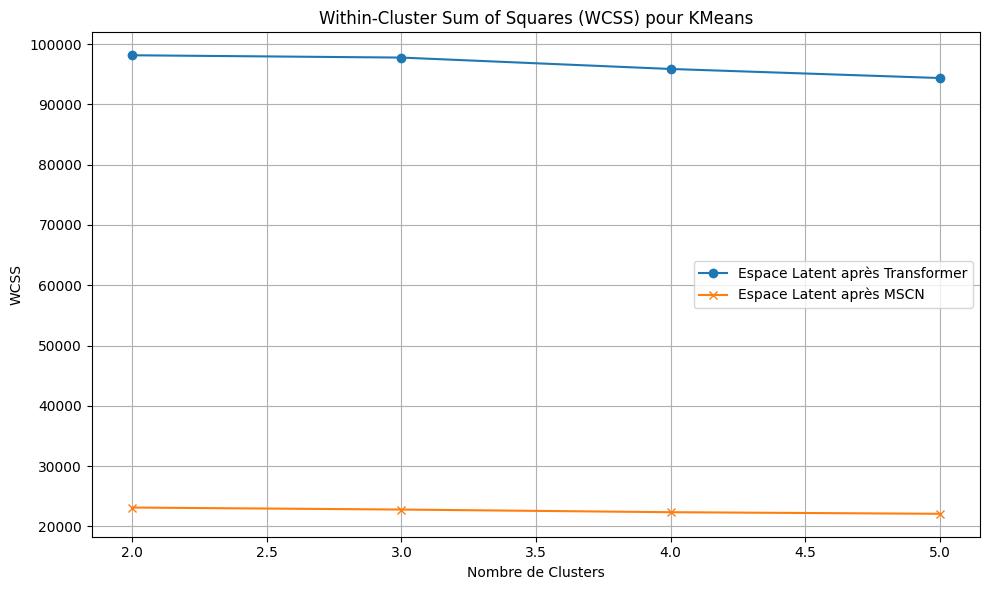

In [59]:
# Calcul du WCSS

"""
Définition : Somme des distances au carré entre chaque point et le centroïde de son cluster.
Interprétation : Plus l'inertie est faible, meilleure est la cohésion des clusters. 
"""

# Initialisation de la liste pour stocker les valeurs de WCSS
wcss1 = []
wcss2 = []
n_clusters = 5  # Nombre de clusters max

# Calcul de WCSS pour les clusters de 2 à n_clusters
for i in range(2, n_clusters + 1):
    kmeans1 = KMeans(n_clusters=i, random_state=42)
    kmeans2 = KMeans(n_clusters=i, random_state=42)
    kmeans1.fit(latentspace1)
    kmeans2.fit(latentspace2)
    wcss1.append(kmeans1.inertia_)
    wcss2.append(kmeans2.inertia_)

# Tracer la courbe de WCSS
plt.figure(figsize=(10, 6))
plt.plot(range(2, n_clusters + 1), wcss1, marker='o', label='Espace Latent après Transformer')
plt.plot(range(2, n_clusters + 1), wcss2, marker='x', label='Espace Latent après MSCN')
plt.title('Within-Cluster Sum of Squares (WCSS) pour KMeans')
plt.xlabel('Nombre de Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when the

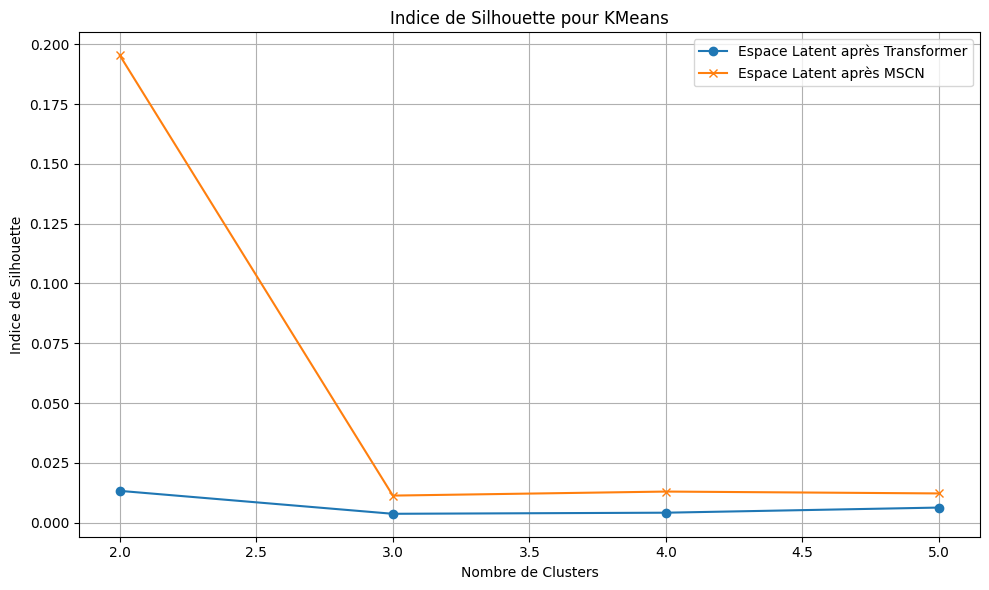

In [60]:
from sklearn.metrics import silhouette_score

"""
Définition : Moyenne de la distance de chaque point à tous les autres points de son cluster et aux clusters les plus proches.
Interprétation : L'indice de silhouette varie de -1 (mauvais) à 1 (bon). 
- Proche de 1 : Les points sont bien regroupés dans leur cluster et éloignés des autres clusters. Cela indique une bonne séparation.
- Proche de 0 : Les points sont à la frontière entre deux clusters, ce qui signifie qu'ils pourraient être assignés à l'un ou l'autre. 
Cela suggère une mauvaise séparation des clusters.
- Négatif : Les points sont probablement mal assignés, car ils sont plus proches des points d'un autre cluster que de ceux de leur propre cluster.
"""

# Initialisation de la liste pour stocker les valeurs de l'indice de silhouette
silhouette_scores1 = []
silhouette_scores2 = []
n_clusters = 5  # Nombre de clusters max

# Calcul de l'indice de silhouette pour les clusters de 2 à n_clusters
for i in range(2, n_clusters + 1):
    kmeans1 = KMeans(n_clusters=i, random_state=42) # ramdom_satate : pour reproduire les résultats
    kmeans2 = KMeans(n_clusters=i, random_state=42)
    kmeans1.fit(latentspace1)
    kmeans2.fit(latentspace2)
    labels1 = kmeans1.labels_  # Récupérer les étiquettes des clusters de l'espace latent après Transformer
    labels2 = kmeans2.labels_  # Récupérer les étiquettes des clusters de l'espace latent après MSCN
    silhouette_avg1 = silhouette_score(latentspace2, labels1)  # Calculer l'indice de silhouette
    silhouette_avg2 = silhouette_score(latentspace2, labels2)  # Calculer l'indice de silhouette
    silhouette_scores1.append(silhouette_avg1)
    silhouette_scores2.append(silhouette_avg2)

# Tracer la courbe de l'indice de silhouette
plt.figure(figsize=(10, 6))
plt.plot(range(2, n_clusters + 1), silhouette_scores1, marker='o', label='Espace Latent après Transformer')
plt.plot(range(2, n_clusters + 1), silhouette_scores2, marker='x', label='Espace Latent après MSCN')
plt.title("Indice de Silhouette pour KMeans")
plt.xlabel("Nombre de Clusters")
plt.ylabel("Indice de Silhouette")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when the

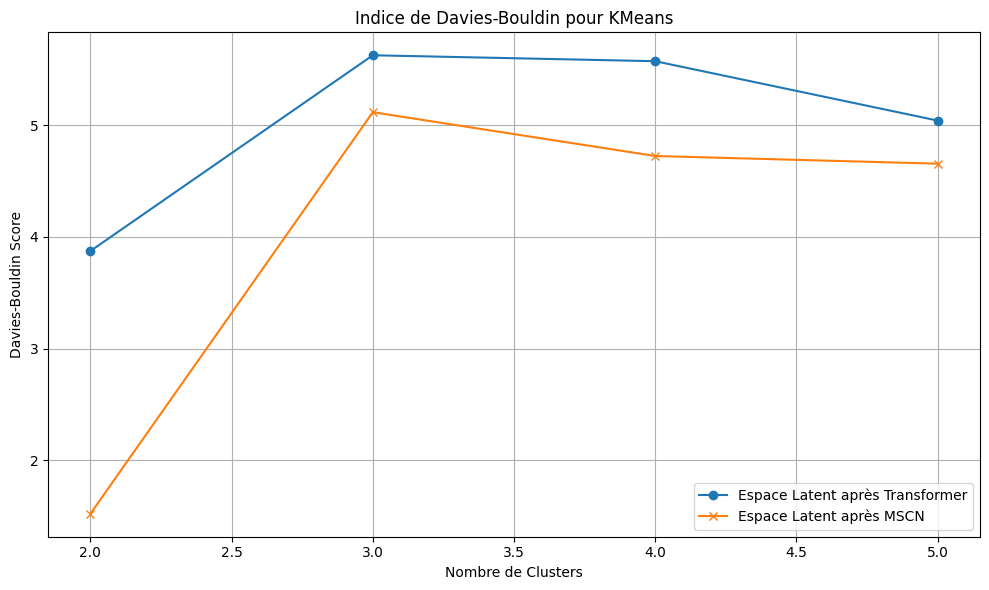

In [62]:
from sklearn.metrics import davies_bouldin_score

"""
Définition : Évalue la compacité et la séparation des clusters.
Interprétation : Une valeur proche de 0 indique une bonne clusterisation. Une valeur supérieure à 1 indique une mauvaise clusterisation.
"""

# Initialisation de la liste pour stocker les valeurs de l'indice de Davies-Bouldin
db_scores1 = []
db_scores2 = []
n_clusters = 5  # Nombre de clusters max

# Calcul de l'indice de Davies-Bouldin pour les clusters de 2 à n_clusters
for i in range(2, n_clusters + 1):
    kmeans1 = KMeans(n_clusters=i, random_state=42)
    kmeans2 = KMeans(n_clusters=i, random_state=42)
    kmeans1.fit(latentspace1)
    kmeans2.fit(latentspace2)
    labels1 = kmeans1.labels_  # Récupérer les étiquettes des clusters pour latentspace1
    labels2 = kmeans2.labels_  # Récupérer les étiquettes des clusters pour latentspace2
    db_score1 = davies_bouldin_score(latentspace1, labels1)  # Calculer l'indice pour latentspace1
    db_score2 = davies_bouldin_score(latentspace2, labels2)  # Calculer l'indice pour latentspace2
    db_scores1.append(db_score1)
    db_scores2.append(db_score2)

# Tracer la courbe de l'indice de Davies-Bouldin
plt.figure(figsize=(10, 6))
plt.plot(range(2, n_clusters + 1), db_scores1, marker='o', label='Espace Latent après Transformer')
plt.plot(range(2, n_clusters + 1), db_scores2, marker='x', label='Espace Latent après MSCN')
plt.title('Indice de Davies-Bouldin pour KMeans')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when the

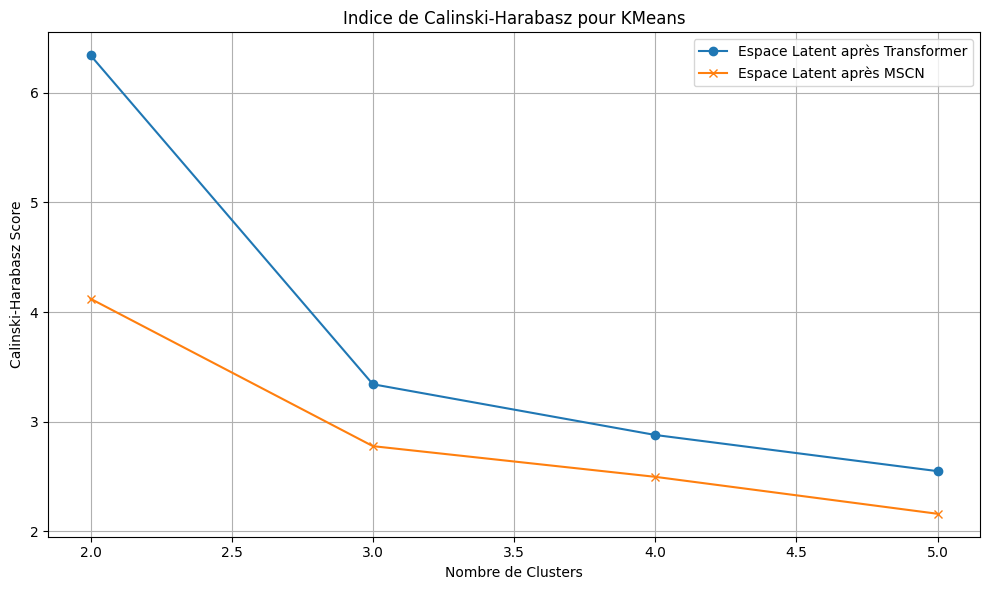

In [61]:
from sklearn.metrics import calinski_harabasz_score

"""
Définition : L'indice de Calinski-Harabasz mesure la séparation et la compacité des clusters.
Interprétation : Plus l'indice est élevé, meilleure est la qualité de la clusterisation. 
"""

# Initialisation de la liste pour stocker les valeurs de l'indice de Calinski-Harabasz
ch_scores1 = []
ch_scores2 = []
n_clusters = 5  # Nombre de clusters max

# Calcul de l'indice de Calinski-Harabasz pour les clusters de 2 à n_clusters
for i in range(2, n_clusters + 1):
    kmeans1 = KMeans(n_clusters=i, random_state=42)
    kmeans2 = KMeans(n_clusters=i, random_state=42)
    kmeans1.fit(latentspace1)
    kmeans2.fit(latentspace2)
    labels1 = kmeans1.labels_  # Récupérer les étiquettes des clusters pour latentspace1
    labels2 = kmeans2.labels_  # Récupérer les étiquettes des clusters pour latentspace2
    ch_score1 = calinski_harabasz_score(latentspace1, labels1)  # Calculer l'indice pour latentspace1
    ch_score2 = calinski_harabasz_score(latentspace2, labels2)  # Calculer l'indice pour latentspace2
    ch_scores1.append(ch_score1)
    ch_scores2.append(ch_score2)

# Tracer la courbe de l'indice de Calinski-Harabasz
plt.figure(figsize=(10, 6))
plt.plot(range(2, n_clusters + 1), ch_scores1, marker='o', label='Espace Latent après Transformer')
plt.plot(range(2, n_clusters + 1), ch_scores2, marker='x', label='Espace Latent après MSCN')
plt.title('Indice de Calinski-Harabasz pour KMeans')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Métrique Supervisées

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when the

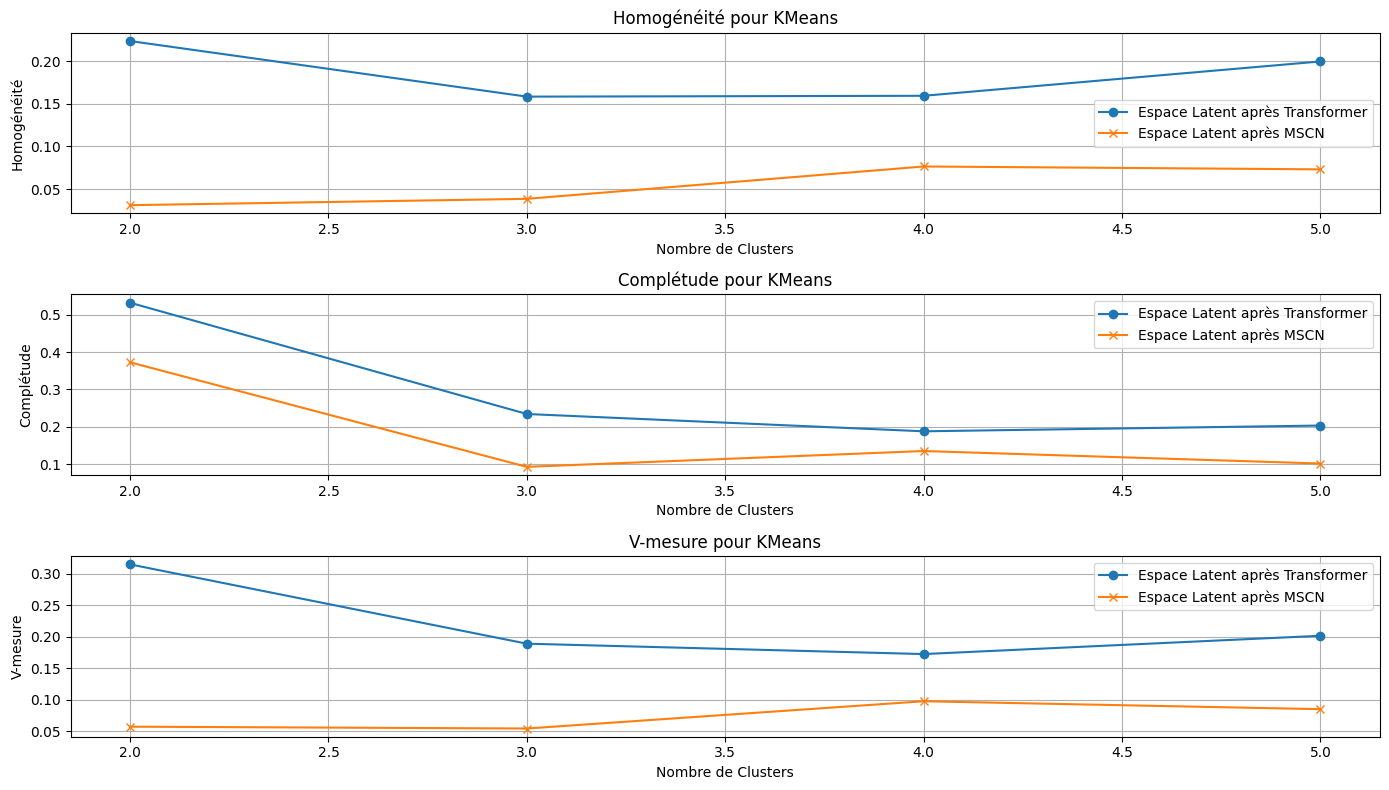

In [ ]:
# Calcul de l'homogénéité, de la complétude et de la V-mesure des clusters créés par KMeans

from sklearn.metrics import homogeneity_completeness_v_measure

"""
Définitions : 
- Homogénéité : Mesure à quel point chaque cluster contient uniquement des points d'une seule classe.
- Complétude : Mesure à quel point tous les points d'une classe donnée sont attribués au même cluster.
- V-mesure : Moyenne harmonique de l'homogénéité et de la complétude.   
Interprétation : Les valeurs de ces métriques varient de 0 à 1, où 1 est le meilleur score.
"""

# Initialisation des listes pour stocker les valeurs des métriques
homogeneity_scores1 = []
completeness_scores1 = []
v_measure_scores1 = []
homogeneity_scores2 = []
completeness_scores2 = []
v_measure_scores2 = []
n_clusters = 5  # Nombre de clusters max

# Calcul des métriques pour les clusters de 2 à n_clusters
for i in range(2, n_clusters + 1):
    kmeans1 = KMeans(n_clusters=i, random_state=42)
    kmeans2 = KMeans(n_clusters=i, random_state=42)
    kmeans1.fit(latentspace1)
    kmeans2.fit(latentspace2)
    labels1 = kmeans1.labels_  # Récupérer les étiquettes des clusters pour latentspace1
    labels2 = kmeans2.labels_  # Récupérer les étiquettes des clusters pour latentspace2
    homogeneity1, completeness1, v_measure1 = homogeneity_completeness_v_measure(target_np, labels1)
    homogeneity2, completeness2, v_measure2 = homogeneity_completeness_v_measure(target_np, labels2)
    homogeneity_scores1.append(homogeneity1)
    completeness_scores1.append(completeness1)
    v_measure_scores1.append(v_measure1)
    homogeneity_scores2.append(homogeneity2)
    completeness_scores2.append(completeness2)
    v_measure_scores2.append(v_measure2)

# Tracer les courbes des métriques
plt.figure(figsize=(14, 8))

# Homogénéité
plt.subplot(3, 1, 1)
plt.plot(range(2, n_clusters + 1), homogeneity_scores1, marker='o', label='Espace Latent après Transformer')
plt.plot(range(2, n_clusters + 1), homogeneity_scores2, marker='x', label='Espace Latent après MSCN')
plt.title('Homogénéité pour KMeans')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Homogénéité')
plt.legend()
plt.grid()

# Complétude
plt.subplot(3, 1, 2)
plt.plot(range(2, n_clusters + 1), completeness_scores1, marker='o', label='Espace Latent après Transformer')
plt.plot(range(2, n_clusters + 1), completeness_scores2, marker='x', label='Espace Latent après MSCN')
plt.title('Complétude pour KMeans')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Complétude')
plt.legend()
plt.grid()

# V-mesure
plt.subplot(3, 1, 3)
plt.plot(range(2, n_clusters + 1), v_measure_scores1, marker='o', label='Espace Latent après Transformer')
plt.plot(range(2, n_clusters + 1), v_measure_scores2, marker='x', label='Espace Latent après MSCN')
plt.title('V-mesure pour KMeans')
plt.xlabel('Nombre de Clusters')
plt.ylabel('V-mesure')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when the

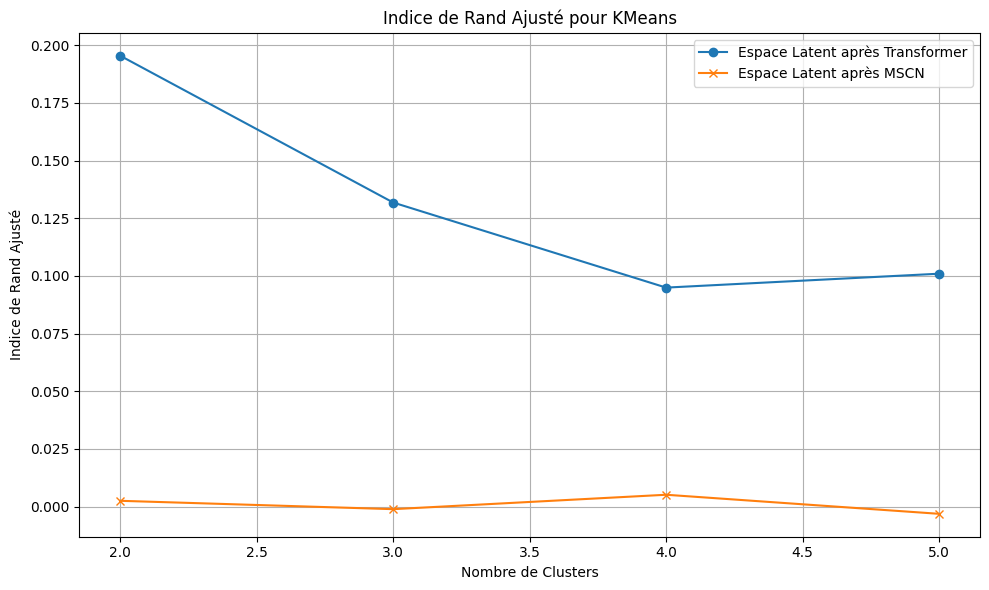

In [ ]:
from sklearn.metrics import adjusted_rand_score

"""
Définition : Mesure la similarité entre deux groupements de données. Ici ces deux regroupements sont les vraies 
étiquettes et les étiquettes prédites par KMeans.
Interprétation : Les valeurs de l'indice de Rand ajusté varient de -1 à 1, où 1 indique une correspondance parfaite 
entre les deux groupements.
"""

# Initialisation des listes pour stocker les valeurs de l'indice de Rand ajusté
adjusted_rand_scores1 = []
adjusted_rand_scores2 = []
n_clusters = 5  # Nombre de clusters max

# Calcul de l'indice de Rand ajusté pour les clusters de 2 à n_clusters
for i in range(2, n_clusters + 1):
    kmeans1 = KMeans(n_clusters=i, random_state=42)
    kmeans2 = KMeans(n_clusters=i, random_state=42)
    kmeans1.fit(latentspace1)
    kmeans2.fit(latentspace2)
    labels1 = kmeans1.labels_  # Récupérer les étiquettes des clusters pour latentspace1
    labels2 = kmeans2.labels_  # Récupérer les étiquettes des clusters pour latentspace2
    adjusted_rand1 = adjusted_rand_score(target_np, labels1)
    adjusted_rand2 = adjusted_rand_score(target_np, labels2)
    adjusted_rand_scores1.append(adjusted_rand1)
    adjusted_rand_scores2.append(adjusted_rand2)

# Tracer les courbes de l'indice de Rand ajusté
plt.figure(figsize=(10, 6))
plt.plot(range(2, n_clusters + 1), adjusted_rand_scores1, marker='o', label='Espace Latent après Transformer')
plt.plot(range(2, n_clusters + 1), adjusted_rand_scores2, marker='x', label='Espace Latent après MSCN')
plt.title('Indice de Rand Ajusté pour KMeans')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Indice de Rand Ajusté')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

d:\debar\anaconda3\envs\envPTI\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when the

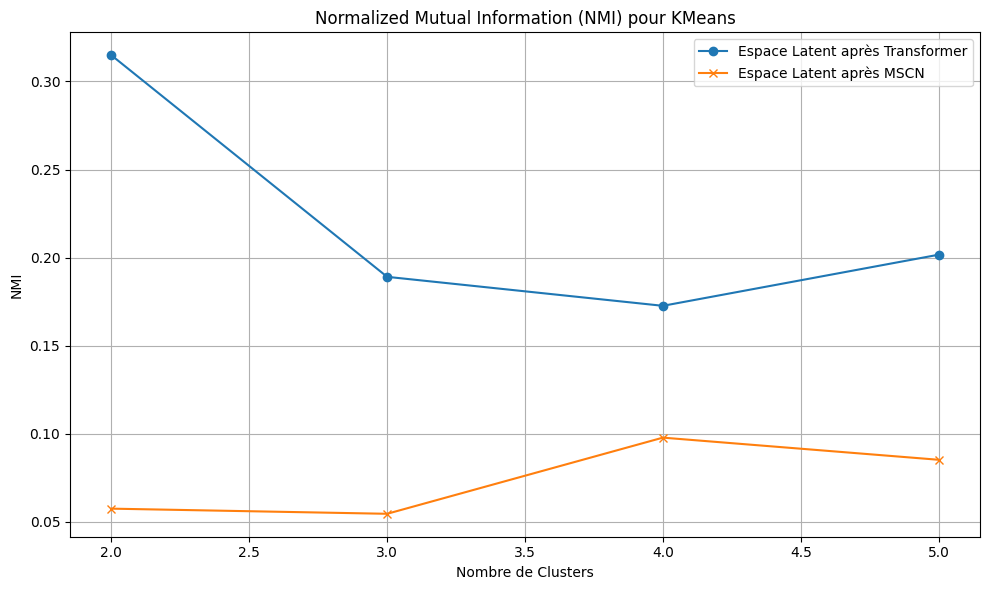

In [66]:
# Calcul de l'information mutuelle normalisée (NMI)

from sklearn.metrics import normalized_mutual_info_score

"""
Définition : Mesure la quantité d'information partagée entre les clusters et les vraies classes.
Interprétation : Les valeurs de NMI varient de 0 à 1, où 1 indique une indique une forte correspondance.
"""

# Initialisation des listes pour stocker les valeurs de NMI
nmi_scores1 = []
nmi_scores2 = []
n_clusters = 5  # Nombre de clusters max

# Calcul de NMI pour les clusters de 2 à n_clusters
for i in range(2, n_clusters + 1):
    kmeans1 = KMeans(n_clusters=i, random_state=42)
    kmeans2 = KMeans(n_clusters=i, random_state=42)
    kmeans1.fit(latentspace1)
    kmeans2.fit(latentspace2)
    labels1 = kmeans1.labels_  # Récupérer les étiquettes des clusters pour latentspace1
    labels2 = kmeans2.labels_  # Récupérer les étiquettes des clusters pour latentspace2
    nmi1 = normalized_mutual_info_score(target_np, labels1)
    nmi2 = normalized_mutual_info_score(target_np, labels2)
    nmi_scores1.append(nmi1)
    nmi_scores2.append(nmi2)

# Tracer la courbe de NMI
plt.figure(figsize=(10, 6))
plt.plot(range(2, n_clusters + 1), nmi_scores1, marker='o', label='Espace Latent après Transformer')
plt.plot(range(2, n_clusters + 1), nmi_scores2, marker='x', label='Espace Latent après MSCN')
plt.title('Normalized Mutual Information (NMI) pour KMeans')
plt.xlabel('Nombre de Clusters')
plt.ylabel('NMI')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()